In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - LLaMA2 (PEFT)

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_llama2_peft.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_llama2_peft.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_pytorch_llama2_peft.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a> (A Python-3 CPU notebook is recommended)
  </td>
</table>

## Overview

This notebook demonstrates downloading and deploying prebuilt [LLaMA2 models](https://huggingface.co/meta-llama). It demonstrates deployment of pre-built LLaMA2 models with vLLM. It demonstrates finetuning and deploying LLaMA2 models with performance efficient finetuning libraries ([PEFT](https://github.com/huggingface/peft)) in Vertex AI, quantizating LLaMA2 models using either AWQ or GPTQ to reduce the GPU memory requirements, and the evaluation of popular benchmark datasets through Vertex CustomJobs using [EleutherAI’s evaluation harness](https://github.com/EleutherAI/lm-evaluation-harness). This notebook uses [Text moderation APIs](https://cloud.google.com/natural-language/docs/moderating-text) to analyze predictions against a list of safety attributes.

### Objective

- Download and deploy prebuilt LLaMA2 models
- Deploy LLaMA2 with [vLLM](https://github.com/vllm-project/vllm) to improve serving throughput
- Finetune and deploy LLaMA2 models with PEFT
- Quantize and deploy LLaMA2 models with AWQ or GPTQ
- Evaluate the LLaMA2 models on any of the benchmark datasets

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage
* Cloud NL APIs

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage pricing](https://cloud.google.com/storage/pricing), [Cloud NL API pricing](https://cloud.google.com/natural-language/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Before you begin

### Colab only
Run the following commands for Colab and skip this section if you are using Workbench.

In [ ]:
import sys

if "google.colab" in sys.modules:
    ! pip3 install --upgrade google-cloud-aiplatform
    ! pip3 install ipython pandas[output_formatting] google-cloud-language==2.10.0
    from google.colab import auth as google_auth

    google_auth.authenticate_user()

    # Restart the notebook kernel after installs.
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Workbench only
If you are using Workbench, you should find that the neccesary dependencies are already pre-installed. If this is not the case or if you have previously modified the existing libraries, you may install the dependencies using the following commands:
```
! pip3 install --upgrade google-cloud-aiplatform
! pip3 install ipython pandas[output_formatting] google-cloud-language==2.10.0
```

### Setup Google Cloud project

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API, Compute Engine API and Cloud Natural Language API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component,language.googleapis.com).

1. [Create a Cloud Storage bucket](https://cloud.google.com/storage/docs/creating-buckets) for storing experiment outputs.

1. [Create a service account](https://cloud.google.com/iam/docs/service-accounts-create#iam-service-accounts-create-console) with `Vertex AI User` and `Storage Object Admin` roles for deploying fine tuned model to Vertex AI endpoint.

### Import the necessary packages

In [ ]:
import json
import os
import sys
from datetime import datetime
from typing import Tuple

from google.cloud import aiplatform, language, storage

Set the following variables for the experiment environment. The specified Cloud Storage bucket (`BUCKET_URI`) should be located in the specified region (`REGION`). Note that a multi-region bucket (eg. "us") is not considered a match for a single region covered by the multi-region range (eg. "us-central1").

In [ ]:
# Cloud project id.
PROJECT_ID = ""  # @param {type:"string"}

# Region for launching jobs.
REGION = ""  # @param {type:"string"}

# Cloud Storage bucket for storing experiments output.
# Start with gs:// prefix, e.g. gs://foo_bucket.
BUCKET_URI = "gs://"  # @param {type:"string"}

! gcloud config set project $PROJECT_ID
! gcloud services enable language.googleapis.com


STAGING_BUCKET = os.path.join(BUCKET_URI, "temporal")
EXPERIMENT_BUCKET = os.path.join(BUCKET_URI, "peft")
BASE_MODEL_BUCKET = os.path.join(EXPERIMENT_BUCKET, "base_model")
MODEL_BUCKET = os.path.join(EXPERIMENT_BUCKET, "model")

# The service account looks like:
# '@.iam.gserviceaccount.com'
# Please go to https://cloud.google.com/iam/docs/service-accounts-create#iam-service-accounts-create-console
# and create service account with `Vertex AI User` and `Storage Object Admin` roles.
# The service account for deploying fine tuned model.
SERVICE_ACCOUNT = ""  # @param {type:"string"}

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user(project_id=PROJECT_ID)

### Initialize Vertex AI API

In [ ]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=STAGING_BUCKET)

### Define constants

In [ ]:
# The pre-built training, serving and evaluation docker images.
TRAIN_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-peft-train:20231211_0936_RC00"
PREDICTION_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-peft-serve:20231129_0948_RC00"
VLLM_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-vllm-serve:20231127_0916_RC00"
VLLM_GPTQ_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-vllm-serve:gptq"
EVAL_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-lm-evaluation-harness:20231011_0934_RC00"

### Define common functions

In [ ]:
def get_job_name_with_datetime(prefix: str) -> str:
    """Gets the job name with date time when triggering training or deployment
    jobs in Vertex AI.
    """
    return prefix + datetime.now().strftime("_%Y%m%d_%H%M%S")


def deploy_model(
    model_name: str,
    model_id: str,
    finetuned_lora_model_path: str,
    service_account: str,
    task: str,
    precision_loading_mode: str = "float16",
    machine_type: str = "n1-standard-8",
    accelerator_type: str = "NVIDIA_TESLA_V100",
    accelerator_count: int = 1,
) -> Tuple[aiplatform.Model, aiplatform.Endpoint]:
    """Deploys trained models into Vertex AI."""
    endpoint = aiplatform.Endpoint.create(display_name=f"{model_name}-endpoint")
    serving_env = {
        "MODEL_ID": model_id,
        "PRECISION_LOADING_MODE": precision_loading_mode,
        "TASK": task,
    }
    if finetuned_lora_model_path:
        serving_env["FINETUNED_LORA_MODEL_PATH"] = finetuned_lora_model_path
    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=PREDICTION_DOCKER_URI,
        serving_container_ports=[7080],
        serving_container_predict_route="/predictions/peft_serving",
        serving_container_health_route="/ping",
        serving_container_environment_variables=serving_env,
    )
    model.deploy(
        endpoint=endpoint,
        machine_type=machine_type,
        accelerator_type=accelerator_type,
        accelerator_count=accelerator_count,
        deploy_request_timeout=1800,
        service_account=service_account,
    )
    return model, endpoint


def deploy_model_vllm(
    model_name: str,
    model_id: str,
    service_account: str,
    machine_type: str = "n1-standard-8",
    accelerator_type: str = "NVIDIA_TESLA_V100",
    accelerator_count: int = 1,
    quantization_method: str = "",
) -> Tuple[aiplatform.Model, aiplatform.Endpoint]:
    """Deploys trained models with vLLM into Vertex AI."""
    endpoint = aiplatform.Endpoint.create(display_name=f"{model_name}-endpoint")

    vllm_args = [
        "--host=0.0.0.0",
        "--port=7080",
        f"--model={model_id}",
        f"--tensor-parallel-size={accelerator_count}",
        "--swap-space=16",
        "--gpu-memory-utilization=0.9",
        "--max-num-batched-tokens=4096",
        "--disable-log-stats",
    ]
    if quantization_method:
        vllm_args.append(f"--quantization={quantization_method}")
    if quantization_method == "gptq":
        vllm_docker_uri = VLLM_GPTQ_DOCKER_URI
    else:
        vllm_docker_uri = VLLM_DOCKER_URI

    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=vllm_docker_uri,
        serving_container_command=["python", "-m", "vllm.entrypoints.api_server"],
        serving_container_args=vllm_args,
        serving_container_ports=[7080],
        serving_container_predict_route="/generate",
        serving_container_health_route="/ping",
    )

    model.deploy(
        endpoint=endpoint,
        machine_type=machine_type,
        accelerator_type=accelerator_type,
        accelerator_count=accelerator_count,
        deploy_request_timeout=1800,
        service_account=service_account,
    )
    return model, endpoint


def moderate_text(text: str) -> language.ModerateTextResponse:
    """Calls Vertex AI APIs to analyze text moderations."""
    client = language.LanguageServiceClient()
    document = language.Document(
        content=text,
        type_=language.Document.Type.PLAIN_TEXT,
    )
    return client.moderate_text(document=document)


def show_text_moderation(text: str, response: language.ModerateTextResponse) -> None:
    """Shows text moderation results."""
    import pandas as pd

    def confidence(category: language.ClassificationCategory) -> float:
        return category.confidence

    columns = ["category", "confidence"]
    categories = sorted(response.moderation_categories, key=confidence, reverse=True)
    data = ((category.name, category.confidence) for category in categories)
    df = pd.DataFrame(columns=columns, data=data)

    print(f"Text analyzed:\n{text}")
    print(df.to_markdown(index=False, tablefmt="presto", floatfmt=".0%"))

## Access LLaMA2 pretrained and finetuned models
The original models from Meta are converted into the Hugging Face format for finetuning and serving in Vertex AI.

Accept the model agreement to access the models:
1. Navigate to the Vertex AI > Model Garden page in the Google Cloud console
2. Find the LLaMA2 model card and click on "VIEW DETAILS"
3. Review the agreement on the model card page
4. After clicking the agreement of LLaMA2, a Cloud Storage bucket containing LLaMA2 pretrained and finetuned models will be shared
5. Paste the Cloud Storage bucket link below and assign it to `VERTEX_AI_MODEL_GARDEN_LLAMA2`

In [ ]:
VERTEX_AI_MODEL_GARDEN_LLAMA2 = ""  # This will be shared once click the agreement of LLaMA2 in Vertex AI Model Garden.
assert (
    VERTEX_AI_MODEL_GARDEN_LLAMA2
), "Please click the agreement of LLaMA2 in Vertex AI Model Garden, and get the GCS path of LLaMA2 model artifacts."
print(
    "Copy LLaMA2 model artifacts from",
    VERTEX_AI_MODEL_GARDEN_LLAMA2,
    "to ",
    BASE_MODEL_BUCKET,
)
! gsutil -m cp -R $VERTEX_AI_MODEL_GARDEN_LLAMA2/* $BASE_MODEL_BUCKET

Set the base model id.

In [ ]:
base_model_name = "llama2-7b-chat-hf"  # @param ["llama2-7b-hf", "llama2-7b-chat-hf", "llama2-13b-hf", "llama2-13b-chat-hf", "llama2-70b-hf", "llama2-70b-chat-hf"]
model_id = os.path.join(BASE_MODEL_BUCKET, base_model_name)

## Deploy prebuilt LLaMA2 models with Google Cloud Text Moderation

This section deploys prebuilt LLaMA2 models on Vertex AI. V100 GPUs are used for demonstration. Note that V100 serving generally offers better throughput and latency performance than L4 serving, while L4 serving is generally more cost efficient than V100 serving. The serving efficiency of V100 and L4 GPUs is inferior to that of A100 GPUs, but V100 and L4 GPUs are nevertheless good serving solutions if you do not have A100 quota.

We use the PEFT serving images to deploy prebuilt LLaMA2 models, by setting finetuning LoRA model paths as empty. The model deployment step will take 15 minutes to 1 hour to complete, depending on the model sizes.

In [ ]:
# Finds Vertex AI prediction supported accelerators and regions in
# https://cloud.google.com/vertex-ai/docs/predictions/configure-compute.

# Sets V100 (16G) to deploy LLaMA2 7B models.
# V100 serving has better throughput and latency performance than L4 serving.
machine_type = "n1-standard-8"
accelerator_type = "NVIDIA_TESLA_V100"
accelerator_count = 1

# Sets 1 L4 (24G) to deploy LLaMA2 7B models.
# L4 serving is more cost efficient than V100 serving.
# machine_type = "g2-standard-8"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 1

# If A100 is not available, you may serve LLaMA2 13B models with multiple V100s
# or L4s. Please keep in mind that the efficiency of serving with multiple
# V100s or L4s is inferior to serving with 1 A100.
# Sets 2 V100 (16G) to deploy LLaMA2 13B models.
# V100 serving has better throughput and latency performance than L4 serving.
# machine_type = "n1-standard-8"
# accelerator_type = "NVIDIA_TESLA_V100"
# accelerator_count = 2

# Sets 2 L4 (24G) to deploy LLaMA2 13B models.
# L4 serving is more cost efficient than V100 serving.
# machine_type = "g2-standard-24"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 2

# Sets A100 (40G) to deploy LLaMA2 13B models.
# machine_type = "a2-highgpu-1g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 1

# Sets 8 L4 (24G) to deploy LLaMA2 70B models.
# If you do not have access to 4 A100 (40G) GPUs, you may serve LLaMA 2 70B
# models with 8 L4 (24G) GPUs.
# Note that with the default timeout threshold of Vertex endpoints, you should
# set a `max_length` configuration of around 1,000 tokens or fewer. If you need
# longer generated sequences, please file a request with Vertex to allowlist
# your project for a longer timeout threshold with Vertex endpoints.
# machine_type = "g2-standard-96"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 8

# Sets 4 A100 (40G) to deploy LLaMA2 70B models.
# machine_type = "a2-highgpu-4g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 4

# The supported precision loading types are "4bit", "8bit", "float16" and "float32".
# Quantization on prebuilt models directly might get poor results.
# Suggests to use float16 for prebuild LLaMA2 model deployments.
precision_loading_mode = "float16"

model_without_peft, endpoint_without_peft = deploy_model(
    model_name=get_job_name_with_datetime(prefix="llama2-serve"),
    model_id=model_id,
    finetuned_lora_model_path="",  # This will avoid override finetuning models.
    service_account=SERVICE_ACCOUNT,
    task="causal-language-modeling-lora",
    precision_loading_mode=precision_loading_mode,
    machine_type=machine_type,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
)
print("endpoint_name:", endpoint_without_peft.name)

NOTE: The prebuilt model weights will be downloaded on the fly from $BASE_MODEL_BUCKET after the deployment succeeds. Thus additional 10 ~ 40 minutes (depending on the model sizes) of waiting time is needed **after** the above model deployment step succeeds and before you run the next step below. Otherwise you might see a `ServiceUnavailable: 503 502:Bad Gateway` error when you send requests to the endpoint.

Once deployment succeeds, you can send requests to the endpoint with text prompts.

Example:

```
Human: What is a car?
Assistant:  A car, or a motor car, is a road-connected human-transportation system used to move people or goods from one place to another. The term also encompasses a wide range of vehicles, including motorboats, trains, and aircrafts. Cars typically have four wheels, a cabin for passengers, and an engine or motor. They have been around since the early 19th century and are now one of the most popular forms of transportation, used for daily commuting, shopping, and other purposes.
```

In [ ]:
# Loads an existing endpoint instance using the endpoint name:
# - Using `endpoint_name = endpoint_without_peft.name` allows us to get the
#   endpoint name of the endpoint `endpoint_without_peft` created in the cell
#   above.
# - Alternatively, you can set `endpoint_name = "1234567890123456789"` to load
#   an existing endpoint with the ID 1234567890123456789.
# You may uncomment the code below to load an existing endpoint.

# endpoint_name = endpoint_without_peft.name
# # endpoint_name = ""  # @param {type:"string"}
# aip_endpoint_name = (
#     f"projects/{PROJECT_ID}/locations/{REGION}/endpoints/{endpoint_name}"
# )
# endpoint_without_peft = aiplatform.Endpoint(aip_endpoint_name)


# Overides max_length and top_k parameters during inferences.
# If you encounter the issue like `ServiceUnavailable: 503 Took too long to respond when processing`,
# you can reduce the max length, such as set max_length as 20.
# If you are using L4 GPUs to serve LLaMA2 70B models, you should set
# max_length to around 1,000 tokens or fewer. If you need longer generated
# sequences, please file a request with Vertex to allowlist your project for a
# longer timeout threshold with Vertex endpoints.
instances = [
    {
        "prompt": "What is a car?",
        "max_tokens": 50,
        "temperature": 1.0,
        "top_p": 1.0,
        "top_k": 10,
    },
]
response = endpoint_without_peft.predict(instances=instances)

for prediction in response.predictions:
    print(prediction)

### Moderate model predictions

Text moderation analyzes a document against a list of safety attributes, which include "harmful categories" and topics that may be considered sensitive.

In [ ]:
for generated_text in response.predictions:
    # Send a request to the API.
    response = moderate_text(generated_text)
    # Show the results.
    show_text_moderation(generated_text, response)

### Build chat applications with LLaMA2

Following the [prompt template recognized by LLaMA2 models](https://huggingface.co/blog/llama2#how-to-prompt-llama-2), you can build multi-turn chat applications while having control over the system prompt.

The output of the Vertex endpoint is `Prompt:\n{{ model_prompt }}\nOutput:\n{{ model_output }}`. You can format this output based on the prompt template to build chat applications in the following way:

In the first turn of the conversation, the user of the chat application sends `user_message_1`. With `user_message_1`, the chat application can formulate `model_prompt` as the following:
```
<s>[INST] <<SYS>>
{{ system_prompt }}
<</SYS>>

{{ user_message }} [/INST]
```
The chat application then sends `model_prompt` to the Vertex endpoint and receives an output of the form: `Prompt:\n{{ model_prompt }}\nOutput:\n{{ model_output }}`. The corresponding endpoint output contains both the original `model_prompt` as well as the generated `model_output`. The chat application can then exact `model_output` to present to the user of the chat application.

In the second turn of the conversation, the user of the chat application sends `user_message_2` and the chat application can formulate `model_prompt` as:
```
<s>[INST] <<SYS>>
{{ system_prompt }}
<</SYS>>

{{ user_message_1 }} [/INST] {{ model_answer_1 }} </s><s>[INST] {{ user_message_2 }} [/INST]
```
where `model_answer_1` is defined to be `model_output` from the previous turn. Again, the Vertex endpoint will generate an output of the form: `Prompt:\n{{ model_prompt }}\nOutput:\n{{ model_output }}`, and the chat application can present `model_output` to the user.

The same approach applies to further turns of the conversation, where all prior user messages and model answers are concatenated in the prompt.

Below we show how [the HuggingFace example](https://huggingface.co/blog/llama2#how-to-prompt-llama-2) can be used with Vertex endpoints. Assume that in the first turn of the conversation, the chat application receives the user message: "There's a llama in my garden 😱 What should I do?"

In [ ]:
instances = [
    {
        "prompt": """<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

There's a llama in my garden 😱 What should I do? [/INST]""",
        "max_tokens": 50,
        "temperature": 1.0,
        "top_p": 1.0,
        "top_k": 10,
    },
]
response = endpoint_without_peft.predict(instances=instances)

endpoint_output = response.predictions[0]
print(f"[Endpoint output]\n{endpoint_output}\n")

model_output_start_index = endpoint_output.find("\nOutput:\n") + len("\nOutput:\n")
model_output = endpoint_output[model_output_start_index:]
print(f"[Model output (model answer) to show the user]\n{model_output}")

## Deploy Prebuilt LLaMA2 with vLLM

This section deploys prebuilt OpenLLaMA models with [vLLM](https://github.com/vllm-project/vllm) on the Endpoint. The model deployment step will take ~15 minutes to complete.

vLLM is an highly optimized LLM serving framework which can increase serving throughput a lot. The higher QPS you have, the more benefits you get using vLLM.

In [ ]:
# Finds Vertex AI prediction supported accelerators and regions in
# https://cloud.google.com/vertex-ai/docs/predictions/configure-compute.

# Sets 1 V100 (16G) to deploy LLaMA2 7B models.
# V100 serving has better throughput and latency performance than L4 serving.
machine_type = "n1-standard-8"
accelerator_type = "NVIDIA_TESLA_V100"
accelerator_count = 1

# Sets 1 L4 (24G) to deploy LLaMA2 7B models.
# L4 serving is more cost efficient than V100 serving.
# machine_type = "g2-standard-8"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 1

# If A100 is not available, you may serve LLaMA2 13B models with multiple V100s
# or L4s. Please keep in mind that the efficiency of serving with multiple
# V100s or L4s is inferior to serving with 1 A100.
# Sets 2 V100 (16G) to deploy LLaMA2 13B models.
# V100 serving has better throughput and latency performance than L4 serving.
# machine_type = "n1-standard-16"
# accelerator_type = "NVIDIA_TESLA_V100"
# accelerator_count = 2

# Sets 2 L4 (24G) to deploy LLaMA2 13B models.
# L4 serving is more cost efficient than V100 serving.
# machine_type = "g2-standard-24"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 2

# Sets A100 (40G) to deploy LLaMA2 13B models.
# machine_type = "a2-highgpu-1g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 1

# Sets 8 L4 (24G) to deploy LLaMA2 70B models.
# If you do not have access to 4 A100 (40G) GPUs, you may serve LLaMA 2 70B
# models with 8 L4 (24G) GPUs.
# machine_type = "g2-standard-96"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 8

# Sets 4 A100 (40G) to deploy LLaMA2 70B models.
# machine_type = "a2-highgpu-4g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 4

model_without_peft_vllm, endpoint_without_peft_vllm = deploy_model_vllm(
    model_name=get_job_name_with_datetime(prefix="llama2-serve-vllm"),
    model_id=model_id,
    service_account=SERVICE_ACCOUNT,
    machine_type=machine_type,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
)

NOTE: The prebuilt model weights will be downloaded on the fly from the orginal location after the deployment succeeds. Thus additional 5 minutes of waiting time is needed **after** the above model deployment step succeeds and before you run the next step below. Otherwise you might see a `ServiceUnavailable: 503 502:Bad Gateway` error when you send requests to the endpoint.

Once deployment succeeds, you can send requests to the endpoint with text prompts. Parameters supported by vLLM can be found [here](https://github.com/vllm-project/vllm/blob/2e8e49fce3775e7704d413b2f02da6d7c99525c9/vllm/sampling_params.py#L23-L64).

In [ ]:
instance = {
    "prompt": "Hi, Google.",
    "n": 1,
    "max_tokens": 50,
    "temperature": 1.0,
    "top_p": 1.0,
    "top_k": 10,
}
response = endpoint_without_peft_vllm.predict(instances=[instance])
print(response.predictions[0])

## Finetune and deploy LLaMA2 models with PEFT

This section demonstrates how to finetune and deploy LLaMA2 models with PEFT LoRA. LoRA (Low-Rank Adaptation) is one approach of PEFT (Parameter Efficient FineTuning), where pretrained model weights are frozen and rank decomposition matrices representing the change in model weights are trained during finetuning. Read more about LoRA in the following publication: [Hu, E.J., Shen, Y., Wallis, P., Allen-Zhu, Z., Li, Y., Wang, S., Wang, L. and Chen, W., 2021. Lora: Low-rank adaptation of large language models. *arXiv preprint arXiv:2106.09685*](https://arxiv.org/abs/2106.09685).

### Finetune

Use the Vertex AI SDK to create and run the custom training jobs with Vertex AI Model Garden training images.

This example uses the dataset [Abirate/english_quotes](https://huggingface.co/datasets/Abirate/english_quotes). You can either use a [dataset from huggingface](https://huggingface.co/datasets) or a custom JSONL dataset in [Vertex text model dataset format](https://cloud.google.com/vertex-ai/docs/generative-ai/models/tune-text-models-supervised#dataset-format) stored in Cloud Storage. The `template` parameter is optional.

#### [Optional] Finetune with a custom dataset

To use a custom dataset, you should supply a `gs://` URI to a JSONL file in [Vertex text model dataset format](https://cloud.google.com/vertex-ai/docs/generative-ai/models/tune-text-models-supervised#dataset-format) in the `dataset_name` below.

For example, here is one data point from the sample dataset `gs://cloud-samples-data/vertex-ai/model-evaluation/peft_train_sample.jsonl`:

```json
{"input_text":"TRANSCRIPT: \nREASON FOR EVALUATION:,\n\n LABEL:","output_text":"Chiropractic"}
```

To use this sample dataset that contains `input_text` and `output_text` fields, set `dataset_name` to `gs://cloud-samples-data/vertex-ai/model-evaluation/peft_train_sample.jsonl` and `template` to `vertex_sample`. For advanced usage with custom datatset fields, see [the template example](https://github.com/tloen/alpaca-lora/blob/main/templates/alpaca.json) and supply your own JSON template as `gs://` URIs.

In [ ]:
# Huggingface dataset name or gs:// URI to a custom JSONL dataset.
dataset_name = "Abirate/english_quotes"  # @param {type:"string"}
# Optional. Template name or gs:// URI to a custom template.
template = ""  # @param {type:"string"}

finetuning_precision_mode = "float16"

# Worker pool spec.
# Finetunes LLaMA2 7B with 1 V100 (16G).
machine_type = "n1-standard-8"
accelerator_type = "NVIDIA_TESLA_V100"
accelerator_count = 1

# Finetunes LLaMA2 7B with 1 L4 (24G).
# machine_type = "g2-standard-8"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 1

# If A100 is not available, you may finetune LLaMA2 13B models with multiple
# V100s or L4s. Please keep in mind that the efficiency of finetuning with
# multiple V100s or L4s is inferior to finetuning with 1 A100.
# Finetunes LLaMA2 13B with 2 V100 (16G).
# machine_type = "n1-standard-8"
# accelerator_type = "NVIDIA_TESLA_V100"
# accelerator_count = 2

# Finetunes LLaMA2 13B with 2 L4 (24G).
# machine_type = "g2-standard-24"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 2

# Finetunes LLaMA2 13B with 1 A100 (40G).
# machine_type = "a2-highgpu-1g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 1

# Finetunes LLaMA2 70B with 8 L4 (24G).
# machine_type = "g2-standard-96"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 8

# Finetunes LLaMA2 70B with 4 A100 (40G).
# machine_type = "a2-highgpu-4g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 4

replica_count = 1


# Setup training job.
job_name = get_job_name_with_datetime("llama2-lora-train")
output_dir = os.path.join(MODEL_BUCKET, job_name)
output_dir_gcsfuse = output_dir.replace("gs://", "/gcs/")

Run the following cell to launch the training job; Or skip to the next section if you want to try hyperparameter tuning with Vertex AI.

In [ ]:
# Pass training arguments and launch job.
train_job = aiplatform.CustomContainerTrainingJob(
    display_name=job_name,
    container_uri=TRAIN_DOCKER_URI,
)
train_job.run(
    args=[
        "--task=causal-language-modeling-lora",
        f"--pretrained_model_id={model_id}",
        f"--dataset_name={dataset_name}",
        f"--output_dir={output_dir}",
        "--lora_rank=16",
        "--lora_alpha=32",
        "--lora_dropout=0.05",
        "--warmup_steps=10",
        "--max_steps=10",
        "--learning_rate=2e-4",
        f"--precision_mode={finetuning_precision_mode}",
        f"--template={template}",
    ],
    environment_variables={"WANDB_DISABLED": True},
    replica_count=replica_count,
    machine_type=machine_type,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
    boot_disk_size_gb=500,
)

print("Trained models were saved in: ", output_dir)

### [Optional] Hyperparameter tuning

You can use the Vertex AI SDK to create and run the [hyperparameter tuning job](https://cloud.google.com/vertex-ai/docs/training/hyperparameter-tuning-overview) to obtain a better performance by experimenting with different hyperparameters such as learning rates.

Define the following specifications:

- `worker_pool_specs`: Dictionary specifying the machine type and Docker image.

- `parameter_spec`: Dictionary specifying the parameters to optimize. The dictionary key is the string assigned to the command line argument for each hyperparameter in your training application code, and the dictionary value is the parameter specification. The parameter specification includes the type, min/max values, and scale for the hyperparameter.

- `metric_spec`: Dictionary specifying the metric to optimize. The dictionary key is the hyperparameter_metric_tag that you set in your training application code, and the value is the optimization goal.

The following 4bit QLoRA experiment results show the effectiveness of hyperparameter tuning evaluated on the ARC Challenge dataset (for reference only):

| Model      | Training time | Trials | Parallel Trials | GPU  | ∆arc challenge | ∆hellaswag | ∆truthfulqa_mc | cost        |
|------------|---------------|--------|-----------------|------|----------------|------------|----------------|-------------|
| Llama2-7b  | 2d 10hrs      | 8      | 1               | L4x1 | +0.73          | +1.61      | +5.34          | \$49.5088    |
| Llama2-13b | 4d 8hrs       | 8      | 1               | L4x1 | +1.53          | +2.11      | +10.98         | \$88.7744    |
| Llama2-70b | 6d 10hrs      | 8      | 2               | L4x4 | +0.77          | +0.93      | +10.63         | \$1,312.5461 |

The following example runs 8 trials on `timdettmers/openassistant-guanaco` with different learning rates, and evaluates the model on `arc_challenge` dataset. You can customize the search space by extending the range of learning rates, adding other parameters such as LoRA rank, etc. Please refer to the [hyperparameter tuning documentation](https://cloud.google.com/vertex-ai/docs/training/hyperparameter-tuning-overview) for more information.

In [ ]:
# Huggingface dataset name or gs:// URI to a custom JSONL dataset.
dataset_name = "timdettmers/openassistant-guanaco"  # @param {type:"string"}
# Optional. Template name or gs:// URI to a custom template.
template = ""  # @param {type:"string"}

hpt_precision_mode = "4bit"

# Worker pool spec for 4bit finetuning.

# Finetunes LLaMA2 7B with 1 L4 (24G).
machine_type = "g2-standard-8"
accelerator_type = "NVIDIA_L4"
accelerator_count = 1

# Finetunes LLaMA2 13B with 1 L4 (24G).
# machine_type = "g2-standard-8"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 1

# Finetunes LLaMA2 70B with 4 L4 (24G).
# machine_type = "g2-standard-48"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 4

### [Optional] Custom evaluation dataset

To obtain a model with better performance on some specific tasks, you might want to run hyperparameter tuning with a custom evaluation dataset. The hyperparameter tuning service will pick the model according to the evaluation dataset and the metrics you selected. You can use any of the following tasks as the `eval_task` in the code cell below:

1. The name of a [lm-evaluation-harness task](https://github.com/EleutherAI/lm-evaluation-harness/tree/big-refactor/lm_eval/tasks).

2. `custom_likelihood`. Then, add a flag `--eval_dataset_path=<Cloud Storage URI to your JSONL dataset>`. The JSONL file must be in the format in Vertex AI language model's [prepare evaluation dataset](https://cloud.google.com/vertex-ai/docs/generative-ai/models/evaluate-models#classification) page.

3. `builtin_eval`. The built-in evaluation loop of the trainer will be used to evaluate the model instead of the [lm-evaluation-harness](https://github.com/EleutherAI/lm-evaluation-harness) library. You can supply any eval dataset in the same format as the training dataset by specifying `--eval_dataset_path`, `--eval_split`, `--eval_template`, and `--eval_column`.

In [ ]:
from google.cloud.aiplatform import hyperparameter_tuning as hpt

eval_task = "arc_challenge"  # @param {type:"string"}
eval_metric_name = "acc_norm"  # @param {type:"string"}

# Runs 10 training steps as a minimal example. Use 1000 to reproduce the experiment results.
max_steps = 10  # @param {type:"integer"}
# Evaluates the model on 10 examples. Use 10000 to reproduce the experiment results.
eval_limit = 10  # @param {type:"integer"}

flags = {
    "learning_rate": 1e-5,
    "precision_mode": hpt_precision_mode,
    "task": "instruct-lora",
    "pretrained_model_id": model_id,
    "output_dir": output_dir,
    "warmup_steps": 10,
    "max_steps": max_steps,
    "lora_rank": 32,
    "lora_alpha": 64,
    "lora_dropout": 0.05,
    "dataset_name": dataset_name,
    "eval_steps": max_steps + 1,  # Only evaluates in the end.
    "eval_tasks": eval_task,
    "eval_limit": eval_limit,
    "eval_metric_name": eval_metric_name,
}

worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": machine_type,
            "accelerator_type": accelerator_type,
            "accelerator_count": accelerator_count,
        },
        "replica_count": replica_count,
        "container_spec": {
            "image_uri": TRAIN_DOCKER_URI,
            "args": ["--{}={}".format(k, v) for k, v in flags.items()],
        },
    }
]
metric_spec = {"model_performance": "maximize"}
parameter_spec = {
    "learning_rate": hpt.DoubleParameterSpec(min=1e-5, max=1e-4, scale="linear"),
}
train_job = aiplatform.CustomJob(
    display_name=job_name,
    worker_pool_specs=worker_pool_specs,
    staging_bucket=STAGING_BUCKET,
)

train_hpt_job = aiplatform.HyperparameterTuningJob(
    display_name=f"{job_name}_hpt",
    custom_job=train_job,
    metric_spec=metric_spec,
    parameter_spec=parameter_spec,
    max_trial_count=8,
    parallel_trial_count=2,
)

train_hpt_job.run()

print("Trained models were saved in: ", output_dir)

Then, find the best trial from the hyperparameter tuning job.

In [ ]:
best_trial_id = max(
    train_hpt_job.trials, key=lambda trial: trial.final_measurement.metrics[0].value
).id
output_dir = os.path.join(output_dir, f"trial_{best_trial_id}")
output_dir_gcsfuse = output_dir.replace("gs://", "/gcs/")
print(f"Best trial {best_trial_id} saved model in:", output_dir)

### Deploy fine tuned models with Google Cloud Text Moderation
This section uploads the model to Model Registry and deploys it on the Endpoint.

The model deployment step will take 15 minutes to 1 hour to complete, depending on the model sizes.

In [ ]:
# Finds Vertex AI prediction supported accelerators and regions in
# https://cloud.google.com/vertex-ai/docs/predictions/configure-compute.

# Sets V100 (16G) to deploy LLaMA2 7B models.
# V100 serving has better throughput and latency performance than L4 serving.
machine_type = "n1-standard-8"
accelerator_type = "NVIDIA_TESLA_V100"
accelerator_count = 1

# Sets 1 L4 (24G) to deploy LLaMA2 7B models.
# L4 serving is more cost efficient than V100 serving.
# machine_type = "g2-standard-8"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 1

# If A100 is not available, you may serve LLaMA2 13B models with multiple V100s
# or L4s. Please keep in mind that the efficiency of serving with multiple
# V100s or L4s is inferior to serving with 1 A100.
# Sets 2 V100 (16G) to deploy LLaMA2 13B models.
# V100 serving has better throughput and latency performance than L4 serving.
# machine_type = "n1-standard-8"
# accelerator_type = "NVIDIA_TESLA_V100"
# accelerator_count = 2

# Sets 2 L4 (24G) to deploy LLaMA2 13B models.
# L4 serving is more cost efficient than V100 serving.
# machine_type = "g2-standard-24"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 2

# Sets A100 (40G) to deploy LLaMA2 13B models.
# machine_type = "a2-highgpu-1g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 1

# Sets 8 L4 (24G) to deploy LLaMA2 70B models.
# If you do not have access to 4 A100 (40G) GPUs, you may serve LLaMA 2 70B
# models with 8 L4 (24G) GPUs.
# Note that with the default timeout threshold of Vertex endpoints, you should
# set a `max_length` configuration of around 1,000 tokens or fewer. If you need
# longer generated sequences, please file a request with Vertex to allowlist
# your project for a longer timeout threshold with Vertex endpoints.
# machine_type = "g2-standard-96"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 8

# Sets 4 A100 (40G) to deploy LLaMA2 70B models.
# machine_type = "a2-highgpu-4g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 4

# The supported precision loading types are "4bit", "8bit", "float16" and "float32".
precision_loading_mode = finetuning_precision_mode

model_with_peft, endpoint_with_peft = deploy_model(
    model_name=get_job_name_with_datetime(prefix="llama2-peft-serve"),
    model_id=model_id,
    finetuned_lora_model_path=output_dir,
    service_account=SERVICE_ACCOUNT,
    task="causal-language-modeling-lora",
    precision_loading_mode=precision_loading_mode,
    machine_type=machine_type,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
)
print("endpoint_name:", endpoint_with_peft.name)

NOTE: After the deployment succeeds, the base model weights will be downloaded on the fly from $BASE_MODEL_BUCKET and LoRA model weights will be downloaded from the GCS bucket used in training above. Thus additional 10 ~ 40 minutes (depending on the model sizes) of waiting time is needed **after** the above model deployment step succeeds and before you run the next step below. Otherwise you might see a `ServiceUnavailable: 503 502:Bad Gateway` error when you send requests to the endpoint.

Once deployment succeeds, you can send requests to the endpoint with text prompts.

Example:

```
Human: What is a car?
Assistant:  A car, or a motor car, is a road-connected human-transportation system used to move people or goods from one place to another. The term also encompasses a wide range of vehicles, including motorboats, trains, and aircrafts. Cars typically have four wheels, a cabin for passengers, and an engine or motor. They have been around since the early 19th century and are now one of the most popular forms of transportation, used for daily commuting, shopping, and other purposes.
```

In [ ]:
# Loads an existing endpoint instance using the endpoint name:
# - Using `endpoint_name = endpoint_with_peft.name` allows us to get the
#   endpoint name of the endpoint `endpoint_with_peft` created in the cell
#   above.
# - Alternatively, you can set `endpoint_name = "1234567890123456789"` to load
#   an existing endpoint with the ID 1234567890123456789.
# You may uncomment the code below to load an existing endpoint.

# endpoint_name = endpoint_with_peft.name
# # endpoint_name = ""  # @param {type:"string"}
# aip_endpoint_name = (
#     f"projects/{PROJECT_ID}/locations/{REGION}/endpoints/{endpoint_name}"
# )
# endpoint_with_peft = aiplatform.Endpoint(aip_endpoint_name)


# Overides max_length and top_k parameters during inferences.
# If you encounter the issue like `ServiceUnavailable: 503 Took too long to respond when processing`,
# you can reduce the max length, such as set max_length as 20.
# If you are using L4 GPUs to serve LLaMA2 70B models, you should set
# max_length to around 1,000 tokens or fewer. If you need longer generated
# sequences, please file a request with Vertex to allowlist your project for a
# longer timeout threshold with Vertex endpoints.
instances = [
    {
        "prompt": "What is a car?",
        "max_tokens": 50,
        "temperature": 1.0,
        "top_p": 1.0,
        "top_k": 10,
    },
]
response = endpoint_with_peft.predict(instances=instances)

for prediction in response.predictions:
    print(prediction)

Text moderation analyzes a document against a list of safety attributes, which include "harmful categories" and topics that may be considered sensitive.

In [ ]:
for generated_text in response.predictions:
    # Send a request to the API.
    response = moderate_text(generated_text)
    # Show the results.
    show_text_moderation(generated_text, response)

## Quantize and deploy LLaMA 2 models

This section demonstrates post-training quantization of LLaMA2 models with Vertex Custom Job. Quantization reduces the memory required by a model while attempting to retain the same performance. Two such algorithms to do so are AWQ and GPTQ. Read more about AWQ in the following publication: [AWQ: Activation-aware Weight Quantization for LLM Compression and Acceleration](https://arxiv.org/abs/2306.00978). Read more about GPTQ in the following publication: [GPTQ: Accurate Post-Training Quantization for Generative Pre-trained Transformers
](https://arxiv.org/abs/2210.17323).

### Deploy pre-quantized models with Google Cloud Text Moderation
Many AWQ-quantized models are provided by TheBloke [here](https://huggingface.co/TheBloke?search_models=-awq), and GPTQ-quantized models are provided [here](https://huggingface.co/TheBloke?search_models=-gptq).

This section uploads the model to Model Registry and deploys it on the Endpoint.

The model deployment step will take 15 minutes to 1 hour to complete, depending on the model sizes.

Notice that deploying a quantized model requires much less GPU.
We can deploy a quantized 13B model with only one L4 instead of four, and
we can deploy a quantized 70B model with only two L4s instead of eight.

In [ ]:
quantized_model_id = "TheBloke/Llama-2-7B-chat-AWQ"  # @param ["TheBloke/Llama-2-7B-chat-AWQ", "TheBloke/Llama-2-13B-chat-AWQ", "TheBloke/Llama-2-70B-chat-AWQ", "TheBloke/Llama-2-7B-chat-GPTQ", "TheBloke/Llama-2-13B-chat-GPTQ", "TheBloke/Llama-2-70B-chat-GPTQ"]

quantization_method = quantized_model_id.split("-")[-1].lower()

# Finds Vertex AI prediction supported accelerators and regions in
# https://cloud.google.com/vertex-ai/docs/predictions/configure-compute.

# Sets 1 L4 (24G) to deploy LLaMA2 7B and 13B models.
machine_type = "g2-standard-8"
accelerator_type = "NVIDIA_L4"
accelerator_count = 1

# Sets 2 L4's (24G) to deploy LLaMA2 70B models.
# machine_type = "g2-standard-24"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 2

model_prequantized_vllm, endpoint_prequantized_vllm = deploy_model_vllm(
    model_name=get_job_name_with_datetime(prefix="llama2-serve-vllm-prequantized"),
    model_id=quantized_model_id,
    service_account=SERVICE_ACCOUNT,
    machine_type=machine_type,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
    quantization_method=quantization_method,
)

NOTE: After the deployment succeeds, the model weights will be downloaded on the fly. Thus additional 10 ~ 40 minutes (depending on the model sizes) of waiting time is needed **after** the above model deployment step succeeds and before you run the next step below. Otherwise you might see a `ServiceUnavailable: 503 502:Bad Gateway` error when you send requests to the endpoint.

Once deployment succeeds, you can send requests to the endpoint with text prompts.

Example:

```
Human: What is a car?
Assistant:  A car, or a motor car, is a road-connected human-transportation system used to move people or goods from one place to another. The term also encompasses a wide range of vehicles, including motorboats, trains, and aircrafts. Cars typically have four wheels, a cabin for passengers, and an engine or motor. They have been around since the early 19th century and are now one of the most popular forms of transportation, used for daily commuting, shopping, and other purposes.
```

In [ ]:
# Loads an existing endpoint instance using the endpoint name:
# - Using `endpoint_name = endpoint_prequantized_vllm.name` allows us to get the
#   endpoint name of the endpoint `endpoint_prequantized_vllm` created in the cell
#   above.
# - Alternatively, you can set `endpoint_name = "1234567890123456789"` to load
#   an existing endpoint with the ID 1234567890123456789.
# You may uncomment the code below to load an existing endpoint.

# endpoint_name = endpoint_prequantized_vllm.name
# # endpoint_name = ""  # @param {type:"string"}
# aip_endpoint_name = (
#     f"projects/{PROJECT_ID}/locations/{REGION}/endpoints/{endpoint_name}"
# )
# endpoint_prequantized_vllm = aiplatform.Endpoint(aip_endpoint_name)


# Overides max_length and top_k parameters during inferences.
# If you encounter the issue like `ServiceUnavailable: 503 Took too long to respond when processing`,
# you can reduce the max length, such as set max_length as 20.
# If you are using L4 GPUs to serve LLaMA2 70B models, you should set
# max_length to around 1,000 tokens or fewer. If you need longer generated
# sequences, please file a request with Vertex to allowlist your project for a
# longer timeout threshold with Vertex endpoints.
instances = [
    {
        "prompt": "What is a car?",
        "max_tokens": 50,
        "temperature": 1.0,
        "top_p": 1.0,
        "top_k": 10,
    },
]
response = endpoint_prequantized_vllm.predict(instances=instances)

for prediction in response.predictions:
    print(prediction)

Text moderation analyzes a document against a list of safety attributes, which include "harmful categories" and topics that may be considered sensitive.

In [ ]:
for generated_text in response.predictions:
    # Send a request to the API.
    response = moderate_text(generated_text)
    # Show the results.
    show_text_moderation(generated_text, response)

### Quantize LLaMA2 models

Quantization reduces the amount of GPU required to serve a model by reducing the bit precision of the weights while minimizing drop in performance. Serving quantized models on VLLM requires models to be quantized to 4 bits. It is recommended to first search if a model has already been quantized and made publicly available: [AWQ](https://huggingface.co/TheBloke?search_models=-awq) and [GPTQ](https://huggingface.co/TheBloke?search_models=-gptq). Quantizing models with AWQ will take around 0.5 hours for LLaMA2 7B, 1.5 hours for LLaMA2 13B, and 4.5 hours for LLaMA2 70B, using 1 NVIDIA_L4 GPU for 7B and 13B models and 8 NVIDIA_L4 GPUs for 70B model. Quantizing models with GPTQ will take around 1.5 hours for LLaMA2 7B, 3 hours for LLaMA2 2.5 hours for LLaMA2 13B, and 6 hours for LLaMA 70B models, using 1 NVIDIA_L4 GPU for 7B and 13B models and 8 NVIDIA_L4 GPUs for 70B model. Finetuned models can also be quantized, so long as the LoRA weights are merged with the base model.

In [ ]:
# Setup quantization job.

# Set `finetuned_model_path` to the GCS path of the merged finetuned model from the section above, if not set, the base model will be quantized.
finetuned_model_path = ""  # @param {type:"string"}
if finetuned_model_path:
    prequantized_model_path = finetuned_model_path
else:
    prequantized_model_path = model_id

quantization_method = "awq"  # @param ["awq", "gptq"]
quantization_job_name = get_job_name_with_datetime(
    f"llama2-{quantization_method}-quantize"
)

quantization_output_dir = os.path.join(MODEL_BUCKET, quantization_job_name)
quantization_output_dir_gcsfuse = quantization_output_dir.replace("gs://", "/gcs/")

# Worker pool spec.

# Sets 1 L4 (24G) to quantize 7B and 13B models.
machine_type = "g2-standard-16"
accelerator_type = "NVIDIA_L4"
accelerator_count = 1

# Sets 8 L4 (24G) to quantize 70B models.
# machine_type = "g2-standard-96"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 8


# Quantization parameters.
quantization_precision_mode = "4bit"
if quantization_method == "awq":
    awq_dataset_name = "pileval"
    group_size = 128
    quantization_args = [
        "--task=quantize-model",
        f"--quantization_method={quantization_method}",
        f"--pretrained_model_id={model_id}",
        f"--quantization_precision_mode={quantization_precision_mode}",
        f"--quantization_output_dir={quantization_output_dir_gcsfuse}",
        f"--quantization_dataset_name={awq_dataset_name}",
        f"--group_size={group_size}",
    ]
else:
    # The original datasets used in GPTQ paper ["wikitext2","c4","c4-new","ptb","ptb-new"].
    gptq_dataset_name = "c4"  # @param {type:"string"}
    gptq_precision_mode = "4bit"
    group_size = -1
    damp_percent = 0.1
    desc_act = True
    quantization_args = [
        "--task=quantize-model",
        f"--quantization_method={quantization_method}",
        f"--pretrained_model_id={model_id}",
        f"--quantization_precision_mode={quantization_precision_mode}",
        f"--quantization_output_dir={quantization_output_dir_gcsfuse}",
        f"--quantization_dataset_name={gptq_dataset_name}",
        f"--group_size={group_size}",
        f"--damp_percent={damp_percent}",
        f"--desc_act={desc_act}",
        "--cache_examples_on_gpu=False",
    ]

# Pass quantization arguments and launch job.
worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": machine_type,
            "accelerator_type": accelerator_type,
            "accelerator_count": accelerator_count,
        },
        "replica_count": 1,
        "disk_spec": {
            "boot_disk_type": "pd-ssd",
            "boot_disk_size_gb": 500,
        },
        "container_spec": {
            "image_uri": TRAIN_DOCKER_URI,
            "env": [
                {
                    "name": "PYTORCH_CUDA_ALLOC_CONF",
                    "value": "max_split_size_mb:32",
                },
            ],
            "command": [],
            "args": quantization_args,
        },
    }
]

print(f"Quantizing {prequantized_model_path}.")
quantize_job = aiplatform.CustomJob(
    display_name=quantization_job_name,
    project=PROJECT_ID,
    worker_pool_specs=worker_pool_specs,
    staging_bucket=STAGING_BUCKET,
)
quantize_job.run()

print("Quantized models were saved in: ", quantization_output_dir)

### Deploy quantized models with Google Cloud Text Moderation
This section uploads the model to Model Registry and deploys it on the Endpoint.

The model deployment step will take 15 minutes to 1 hour to complete, depending on the model sizes.

Notice that deploying a quantized model requires much less GPU.
We can deploy a quantized 13B model with only one L4 instead of four, and
we can deploy a quantized 70B model with only two L4s instead of eight.

In [ ]:
# Finds Vertex AI prediction supported accelerators and regions in
# https://cloud.google.com/vertex-ai/docs/predictions/configure-compute.

# Sets 1 L4 (24G) to deploy LLaMA2 7B and 13B models.
machine_type = "g2-standard-8"
accelerator_type = "NVIDIA_L4"
accelerator_count = 1

# Sets 2 L4's (24G) to deploy LLaMA2 70B models.
# machine_type = "g2-standard-24"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 2

model_quantized_vllm, endpoint_quantized_vllm = deploy_model_vllm(
    model_name=get_job_name_with_datetime(prefix="llama2-serve-vllm-quantized"),
    model_id=quantization_output_dir,
    service_account=SERVICE_ACCOUNT,
    machine_type=machine_type,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
    quantization_method=quantization_method,
)

NOTE: After the deployment succeeds, the model weights will be downloaded on the fly. Thus additional 10 ~ 40 minutes (depending on the model sizes) of waiting time is needed **after** the above model deployment step succeeds and before you run the next step below. Otherwise you might see a `ServiceUnavailable: 503 502:Bad Gateway` error when you send requests to the endpoint.

Once deployment succeeds, you can send requests to the endpoint with text prompts.

Example:

```
Human: What is a car?
Assistant:  A car, or a motor car, is a road-connected human-transportation system used to move people or goods from one place to another. The term also encompasses a wide range of vehicles, including motorboats, trains, and aircrafts. Cars typically have four wheels, a cabin for passengers, and an engine or motor. They have been around since the early 19th century and are now one of the most popular forms of transportation, used for daily commuting, shopping, and other purposes.
```

In [ ]:
# Loads an existing endpoint instance using the endpoint name:
# - Using `endpoint_name = endpoint_quantized_vllm.name` allows us to get the
#   endpoint name of the endpoint `endpoint_quantized_vllm` created in the cell
#   above.
# - Alternatively, you can set `endpoint_name = "1234567890123456789"` to load
#   an existing endpoint with the ID 1234567890123456789.
# You may uncomment the code below to load an existing endpoint.

# endpoint_name = endpoint_quantized_vllm.name
# # endpoint_name = ""  # @param {type:"string"}
# aip_endpoint_name = (
#     f"projects/{PROJECT_ID}/locations/{REGION}/endpoints/{endpoint_name}"
# )
# endpoint_quantized_vllm = aiplatform.Endpoint(aip_endpoint_name)


# Overides max_length and top_k parameters during inferences.
# If you encounter the issue like `ServiceUnavailable: 503 Took too long to respond when processing`,
# you can reduce the max length, such as set max_length as 20.
# If you are using L4 GPUs to serve LLaMA2 70B models, you should set
# max_length to around 1,000 tokens or fewer. If you need longer generated
# sequences, please file a request with Vertex to allowlist your project for a
# longer timeout threshold with Vertex endpoints.
instances = [
    {
        "prompt": "What is a car?",
        "max_tokens": 50,
        "temperature": 1.0,
        "top_p": 1.0,
        "top_k": 10,
    },
]
response = endpoint_quantized_vllm.predict(instances=instances)

for prediction in response.predictions:
    print(prediction)

Text moderation analyzes a document against a list of safety attributes, which include "harmful categories" and topics that may be considered sensitive.

In [ ]:
for generated_text in response.predictions:
    # Send a request to the API.
    response = moderate_text(generated_text)
    # Show the results.
    show_text_moderation(generated_text, response)

## Evaluate PEFT-finetuned LLaMA 2 models

This section demonstrates evaluation of LLaMA2 models using EleutherAI's [Language Model Evaluation Harness (lm-evaluation-harness)](https://github.com/EleutherAI/lm-evaluation-harness) with Vertex Custom Job. Please reference the peak GPU memory usgaes for serving and adjust the machine type, accelerator type and accelerator count accordingly.

This example uses the dataset [TruthfulQA](https://arxiv.org/abs/2109.07958).
All the supported tasks are listed in [this task table](https://github.com/EleutherAI/lm-evaluation-harness/blob/master/docs/task_table.md).

In [ ]:
# Set the machine_type, accelerator_type, accelerator_count and benchmark dataset.
eval_dataset = "truthfulqa_mc"  # @param ["truthfulqa_mc", "boolq", "gsm8k", "hellaswag", "natural_questions", "openai_humaneval", "openbookqa", "quac", "trivia_qa", "winograde"]

# Worker pool spec.
# Find Vertex AI supported accelerators and regions in:
#  https://cloud.google.com/vertex-ai/docs/training/configure-compute

# Sets V100 (16G) to evaluate LLaMA2 7B models.
machine_type = "n1-standard-8"
accelerator_type = "NVIDIA_TESLA_V100"
accelerator_count = 1

# Sets 1 L4 (24G) to evaluate LLaMA2 7B models.
# machine_type = "g2-standard-8"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 1

# Sets 2 V100 (16G) to evaluate LLaMA2 13B models.
# machine_type = "n1-standard-8"
# accelerator_type = "NVIDIA_TESLA_V100"
# accelerator_count = 2

# Sets 2 L4 (24G) to evaluate LLaMA2 13B models.
# machine_type = "g2-standard-24"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 2

# Sets A100 (40G) to evaluate LLaMA2 13B models.
# machine_type = "a2-highgpu-1g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 1

# Sets 8 L4 (24G) to evaluate LLaMA2 70B models.
# machine_type = "g2-standard-96"
# accelerator_type = "NVIDIA_L4"
# accelerator_count = 8

# Sets 4 A100 (40G) to evaluate LLaMA2 70B models.
# machine_type = "a2-highgpu-4g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 4

# Sets A100 (80G) to evaluate LLaMA2 70B models for faster inferences.
# machine_type = "a2-ultragpu-1g"
# accelerator_type = "NVIDIA_TESLA_A100_80GB"
# accelerator_count = 2

replica_count = 1

In [ ]:
# Setup evaluation job.
job_name = get_job_name_with_datetime(prefix="llama2-eval")
eval_output_dir = os.path.join(MODEL_BUCKET, job_name)
eval_output_dir_gcsfuse = eval_output_dir.replace("gs://", "/gcs/")
model_id_gcsfuse = model_id.replace("gs://", "/gcs/")

In [ ]:
# Prepare evaluation command that runs the evaluation harness.
# Set `trust_remote_code = True` because evaluating the model requires
# executing code from the model repository.
# Set `use_accelerate = True` to enable evaluation across multiple GPUs.
eval_command = [
    "python",
    "main.py",
    "--model",
    "hf-causal-experimental",
    "--model_args",
    f"pretrained={model_id_gcsfuse},peft={output_dir_gcsfuse},trust_remote_code=True,use_accelerate=True,device_map_option=auto",
    "--tasks",
    f"{eval_dataset}",
    "--output_path",
    f"{eval_output_dir_gcsfuse}",
]

In [ ]:
# Run the evaluation job.
worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": machine_type,
            "accelerator_type": accelerator_type,
            "accelerator_count": accelerator_count,
        },
        "replica_count": replica_count,
        "disk_spec": {
            "boot_disk_size_gb": 500,
        },
        "container_spec": {
            "image_uri": EVAL_DOCKER_URI,
            "command": eval_command,
            "args": [],
        },
    }
]

eval_job = aiplatform.CustomJob(
    display_name=job_name,
    worker_pool_specs=worker_pool_specs,
    base_output_dir=eval_output_dir,
)

eval_job.run()

print("Evaluation results were saved in:", eval_output_dir)

In [ ]:
# Fetch evaluation results.
storage_client = storage.Client()
BUCKET_NAME = BUCKET_URI.replace("gs://", "")
bucket = storage_client.get_bucket(BUCKET_NAME)
RESULT_FILE_PATH = eval_output_dir[len(BUCKET_URI) + 1 :]
blob = bucket.blob(RESULT_FILE_PATH)
raw_result = blob.download_as_string()

# Print evaluation results.
result = json.loads(raw_result)
result_formatted = json.dumps(result, indent=2)
print(f"Evaluation result:\n{result_formatted}")

## Clean up resources

In [ ]:
if train_job._gca_resource.name:
    # Training job is submitted.
    train_job.delete()
# Uncomment the following line to delete the hyperparameter tuning job if you
# have created one.
# train_hpt_job.delete()

# Delete the evaluation job.
eval_job.delete()

# Delete the quantization job.
quantize_job.delete()

# Undeploy model and delete endpoint.
endpoint_without_peft.delete(force=True)
endpoint_with_peft.delete(force=True)
endpoint_without_peft_vllm.delete(force=True)
endpoint_prequantized_vllm.delete(force=True)
endpoint_quantized_vllm.delete(force=True)

# Delete models.
model_without_peft.delete()
model_with_peft.delete()
model_without_peft_vllm.delete()
model_prequantized_vllm.delete()
model_quantized_vllm.delete()

# Delete Cloud Storage objects that were created
delete_bucket = False
if delete_bucket:
    ! gsutil -m rm -r $EXPERIMENT_BUCKET

# Vertex AI Model Garden - LLaMA2 (RLHF)

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_llama2_peft.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_llama2_peft.ipynb">
        <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
    <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_pytorch_llama2_peft.ipynb">
       <img src="https://www.gstatic.com/cloud/images/navigation/vertex-ai.svg" alt="Vertex AI logo">Open in Vertex AI Workbench
    </a>
</table>

## Overview

This tutorial demonstrates how to use Vertex AI RLHF to tune a LLaMA2. This workflow improves a model's accuracy by fine-tuning a base model with a training dataset.


### Objective

In this tutorial, you will use `Vertex AI RLHF` to tune a large language model model, perform bulk inference and model deployment.


This tutorial uses the following Google Cloud ML services:

- `Vertex AI RLHF`
- `Vertex AI Pipelines`


The steps performed include:

- Set the number of model tuning steps.
- Create Vertex AI Pipeline job using a predefined template for tuning.
- Execute the pipeline using `Vertex AI Pipelines`.
- Perform online prediction with the tuned model.

### Prepare your inputs

In the sample below, you will run RLHF training on LLaMA 2 70B chat model. A list of supported models, hardware and regions can be found as follows. Tuning jobs that run in us-central1 will use 8 Nvidia A100 80GB. Jobs that run in europe-west4 will use 64 v3 TPUs.

**Table 1. Supported models, hardware and regions**

| large_model_reference | supported accelerator_type | supported region |
|---|---|---|
|  `llama-2-7b` | `TPU_V3`, `NVIDIA_TESLA_A100` | europe-west4, us-central1 |
|  `llama-2-7b-chat` | `TPU_V3`, `NVIDIA_TESLA_A100` | europe-west4, us-central1 |
|  `llama-2-13b` | `TPU_V3`, `NVIDIA_TESLA_A100` | europe-west4, us-central1 |
|  `llama-2-13b-chat` | `TPU_V3`, `NVIDIA_TESLA_A100` | europe-west4, us-central1 |

The workflow takes the following inputs:

* **preference_dataset**: Required, `str`. Cloud storage path to a human preference dataset used to train a reward model. Download the [example dataset](https://pantheon.corp.google.com/storage/browser/vertex-ai/generative-ai/rlhf/text_small/summarize_from_feedback_tfds/comparisons/train?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&e=13802955&jsmode=O&mods=-ai_platform_fake_service&project=vertex-ai&prefix=&forceOnObjectsSortingFiltering=false), and see its content.
> The dataset format is `jsonl`. Each line in the file contains one example:
> * An `input_text` field containing the prompt.
> * `candidate_0`, `candidate_1` fields containing the candidate responses.
> * A `choice` field that specifies which candidate is preferred. This field is an integer `0` or `1`. `0` means `candidate_0` is preferred, `1` means `candidate_1` is preferred.
> * For example: `{"input_text": "Create a description for Plantation Palms.", "candidate_0": "Enjoy some fun in the sun at Gulf Shores.", "candidate_1": "A Tranquil Oasis of Natural Beauty.", "choice": 0}`

* **prompt_dataset**: Required, `str`. Cloud storage path to an unlabled prompt dataset used for reinforcement learning. Download the [example dataset](https://pantheon.corp.google.com/storage/browser/vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/train?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&e=13802955&jsmode=O&mods=-ai_platform_fake_service&project=vertex-ai&prefix=&forceOnObjectsSortingFiltering=false), and see its content.
> The dataset format is `jsonl`. Each line in the file contains one example:
> * An `input_text` field containing the prompt.
> * For example: `{"input_text": "Create a description for Plantation Palms."}`

* **eval_dataset**: Optional, `str`. Cloud storage path to the unlabeled dataset you want to do prediction on. If provided, inference will be performed on this dataset after training. Its format is exactly the same as **prompt_dataset**.

* **large_model_reference**: Required, `str`. Name of the base model. In this example, we use `text-bison@001`. Valid values are listed in the table above.

* **model_display_name**: Optional, `str`. Name of the fine-tuned model shown in the Model Registry. If not provided, a default name will be created.

* **reward_model_train_steps**: Optional, `int`. Number of steps to use when training a reward model. Default value is 1000.

* **reinforcement_learning_train_steps**: Optional, `int`. Number of reinforcement learning steps to perform when tuning a base model. Default value is 1000.

* **prompt_sequence_length**: Optional, `int`. Maximum tokenized sequence length for input text. Higher values increase memory overhead. This value should be at most `8192`. Default value is `512`.

* **target_sequence_length**: Optional, `int`. Maximum tokenized sequence length for target text. Higher values increase memory overhead. This value should be at most `1024`. Default value is `64`.

* **reward_model_learning_rate_multiplier**: Optional, `float`. Constant used to adjust the base learning rate used when training a reward model. Multiply by a number > 1 to increase the magnitude of updates applied at each training step or multiply by a number < 1 to decrease the magnitude of updates. Default value is `1.0`.

* **reinforcement_learning_rate_multiplier**: Optional, `float`. Constant used to adjust the base learning rate used during reinforcement learning. Multiply by a number > 1 to increase the magnitude of updates applied at each training step or multiply by a number < 1 to decrease the magnitude of updates. Default value is `1.0`.

* **kl_coeff**: Optional, `float`. Coefficient for KL penalty. This regularizes the policy model and penalizes if it diverges from its initial distribution. If set to 0, the reference language model is not loaded into memory. Default value is `0.1`.

* **lora_dim**: Optional, `int`. Default value is 4. If set to 0, full-model tuning is performed.

* **instruction**: Optional, `str`. This field lets the model know what task it needs to perform. Base models have been trained over a large set of varied instructions. You can give a simple and intuitive description of the task and the model will follow it, e.g. `Classify this movie review as positive or negative` or `Translate this sentence to Danish`. See [here](https://ai.googleblog.com/2021/10/introducing-flan-more-generalizable.html) for more details on the instruction-tuned models. Do not specify this if your dataset already prepends the instruction to the inputs field.

### A Note on choosing train_steps

Choosing a suitable value for the number of train steps can help avoid overfitting.

* **reward_model_train_steps**: This depends on the size of your "comparison dataset". Usually, the model should train over the comparison dataset for 20-30 times for best results.

* **reinforcement_learning_train_steps**: This depends on the size of your prompt dataset. Usually, the model should train over the prompt dataset for roughly 10-20 times, but beware, if given too many training steps, the policy model may figure out a way exploit the reward and exhibit undesired behavior (i.e. "reward hacking").

The calculator below can help you compute these numbers.

In [ ]:
# Please REPLACE with your own parameters for:
# - N_COMPARISON_DATASET_EXAMPLES
# - N_REWARD_MODEL_TRAINER_EPOCHS
# - N_PROMPT_DATASET_EXAMPLES
# - N_REINFORCER_EPOCHS
# - BATCH_SIZE

import math

# This is your "preference dataset" size.
N_PREFERENCE_DATASET_EXAMPLES = 3000
# An epoch refers to one full cycle through the training dataset.
N_REWARD_MODEL_TRAIN_EPOCHS = 30

# This is your "prompt dataset" size.
N_PROMPT_DATASET_EXAMPLES = 2000
# An epoch refers to one full cycle through the training dataset.
N_REINFORCEMENT_LEARNING_TRAIN_EPOCHS = 10

BATCH_SIZE = 64  # We use fixed batch_size=64 under the hood.

reward_model_train_steps = math.ceil(
    N_PREFERENCE_DATASET_EXAMPLES * N_REWARD_MODEL_TRAIN_EPOCHS / BATCH_SIZE
)  # 3000 * 30 / 64 = 1407

reinforcement_learning_train_steps = math.ceil(
    N_PROMPT_DATASET_EXAMPLES * N_REINFORCEMENT_LEARNING_TRAIN_EPOCHS / BATCH_SIZE
)  # 2000 * 10 / 64 = 313

print(f"{reward_model_train_steps=}")
print(f"{reinforcement_learning_train_steps=}")

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

Install the following packages required to execute this notebook.

In [ ]:
! pip3 install --upgrade --quiet google-cloud-aiplatform google-cloud-pipeline-components kfp


### Colab only: Uncomment the following cell to restart the kernel

Automatically restart kernel after installs so that your environment can access the new packages

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Before you begin

### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = "llm-experiment-393119"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

#### Region

You can also change the `REGION` variable used by Vertex AI. For preview, only `us-central1` and `europe-west4` are supported.

In [ ]:
REGION = "europe-west4"

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may need to authenticate manually. Follow the relevant instructions below.

#### Vertex AI Workbench
Do nothing as you are already authenticated.

#### Local JupyterLab instance

**1. Uncomment and run:**

In [ ]:
! gcloud auth login


**2. Colab, uncomment and run:**

In [ ]:
from google.colab import auth

auth.authenticate_user()

**3. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Define a storage bucket to store pipeline artifacts.

In [ ]:
BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't exist already**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI


#### Service Account

A service account is needed to create Vertex AI Pipeline jobs. If you don't know your service account, try to get your service account using gcloud command by executing the second cell below.

In [ ]:
SERVICE_ACCOUNT = "[your-service-account]"  # @param {type:"string"}

In [ ]:
import sys

IS_COLAB = "google.colab" in sys.modules
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your service account from gcloud
    if not IS_COLAB:
        shell_output = !gcloud auth list 2>/dev/null
        SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

    else:  # IS_COLAB:
        shell_output = ! gcloud projects describe  $PROJECT_ID
        project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
        SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

    print("Service Account:", SERVICE_ACCOUNT)

#### Set service account access for Vertex AI Pipelines

Run the following commands to grant your service account access to read and write pipeline artifacts in the bucket that you created in the previous step. You only need to run this step once per service account.

In [ ]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI


## Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [ ]:
import google.cloud.aiplatform as aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

## Construct the Pipeline Job and Run on Vertex AI

Define a pipeline job with the following code, which will:

- load the pipeline template that was compiled in the previous step, and
- set pipeline parameters. (See [Prepare your inputs](https://colab.research.google.com/drive/1SGSTAW3dcANbU_d3g5mSGCN9LXf5cA1p?resourcekey=0-NAfp-Rrb9piBiJbvqa6bqA#scrollTo=aef4f59195ad&line=61&uniqifier=1) section above for the definition of these parameters.)


In [ ]:
# Create a job via the pipeline template compiled in the previous step:
job = aiplatform.PipelineJob(
    display_name="tutorial-rlhf-tuning",
    pipeline_root=f"{BUCKET_URI}/rlhf",
    template_path="https://us-kfp.pkg.dev/ml-pipeline/llm-rlhf/rlhf-llama-train-template/stable",
    parameter_values={
        "preference_dataset": "gs://vertex-ai/generative-ai/rlhf/text_small/summarize_from_feedback_tfds/comparisons/train/*.jsonl",
        "prompt_dataset": "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/train/*.jsonl",
        "eval_dataset": "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/val/*.jsonl",
        "large_model_reference": "llama-2-7b-chat",  # see Table 1 for valid values.
        "model_display_name": "my_rlhf_tutorial_model",  # Optional. If omitted, a default model_display_name will be created.
        "reward_model_train_steps": 100,  # Please remember to read "A Note on choosing train_steps" section.
        "reinforcement_learning_train_steps": 100,  # Please remember to read "A Note on choosing train_steps" section.
        "prompt_sequence_length": 512,
        "target_sequence_length": 64,
        "reward_model_learning_rate_multiplier": 1.0,
        "reinforcement_learning_rate_multiplier": 1.0,
        "kl_coeff": 0.1,
        "lora_dim": 4,
        "instruction": "Summarize in less than 50 words.",
    },
)

### Run the pipeline using Vertex AI Pipelines

Execute the following cell to run the pipeline on Vertex AI.

In [ ]:
job.run()

### View pipeline job in UI

Go to "Vertex AI Pipelines" in the Google Cloud UI to view the pipeline job. When the pipeline completes, click on the **Reinforcer** step. In the output parameters section you should see the output model's GCS path.
* If you tuned an open-source model (like the T5 models), the output model will be in your project's GCS buckets. You will be able to download the tuned model.
* If you tuned PaLM 2 models, the output model will be in a restricted-access GCS bucket. You won't be able to download the tuned model.

### Look at training loss and reward using Tensorboard

The **RewardModelTrainer** and **Reinforcer** output the training time `rank_loss`, `reward`, `kl_loss` to tensorboard to help you examine training curves and decide how to tune hyper-parameters.

Click on the **tensorboard_metrics** > `URI` attached to **RewardModelTrainer** and **Reinforcer**. If you encounter "❗ Requested entity was not found", this is a known issue. Hit the backarrow at the top of the page, then > `tensorboard_metrics/` > `train/` > some filename that looks like `events.out.tfevents.*-w-1.1.0.v2`. This is the tensorboard file. Download the tensorboard files from both RewardModelTrainer and Reinforcer.

Visualize the tensorboards using the [tensorboard python package](https://pypi.org/project/tensorboard/). It will give you some loss curves that looks like the curves below.


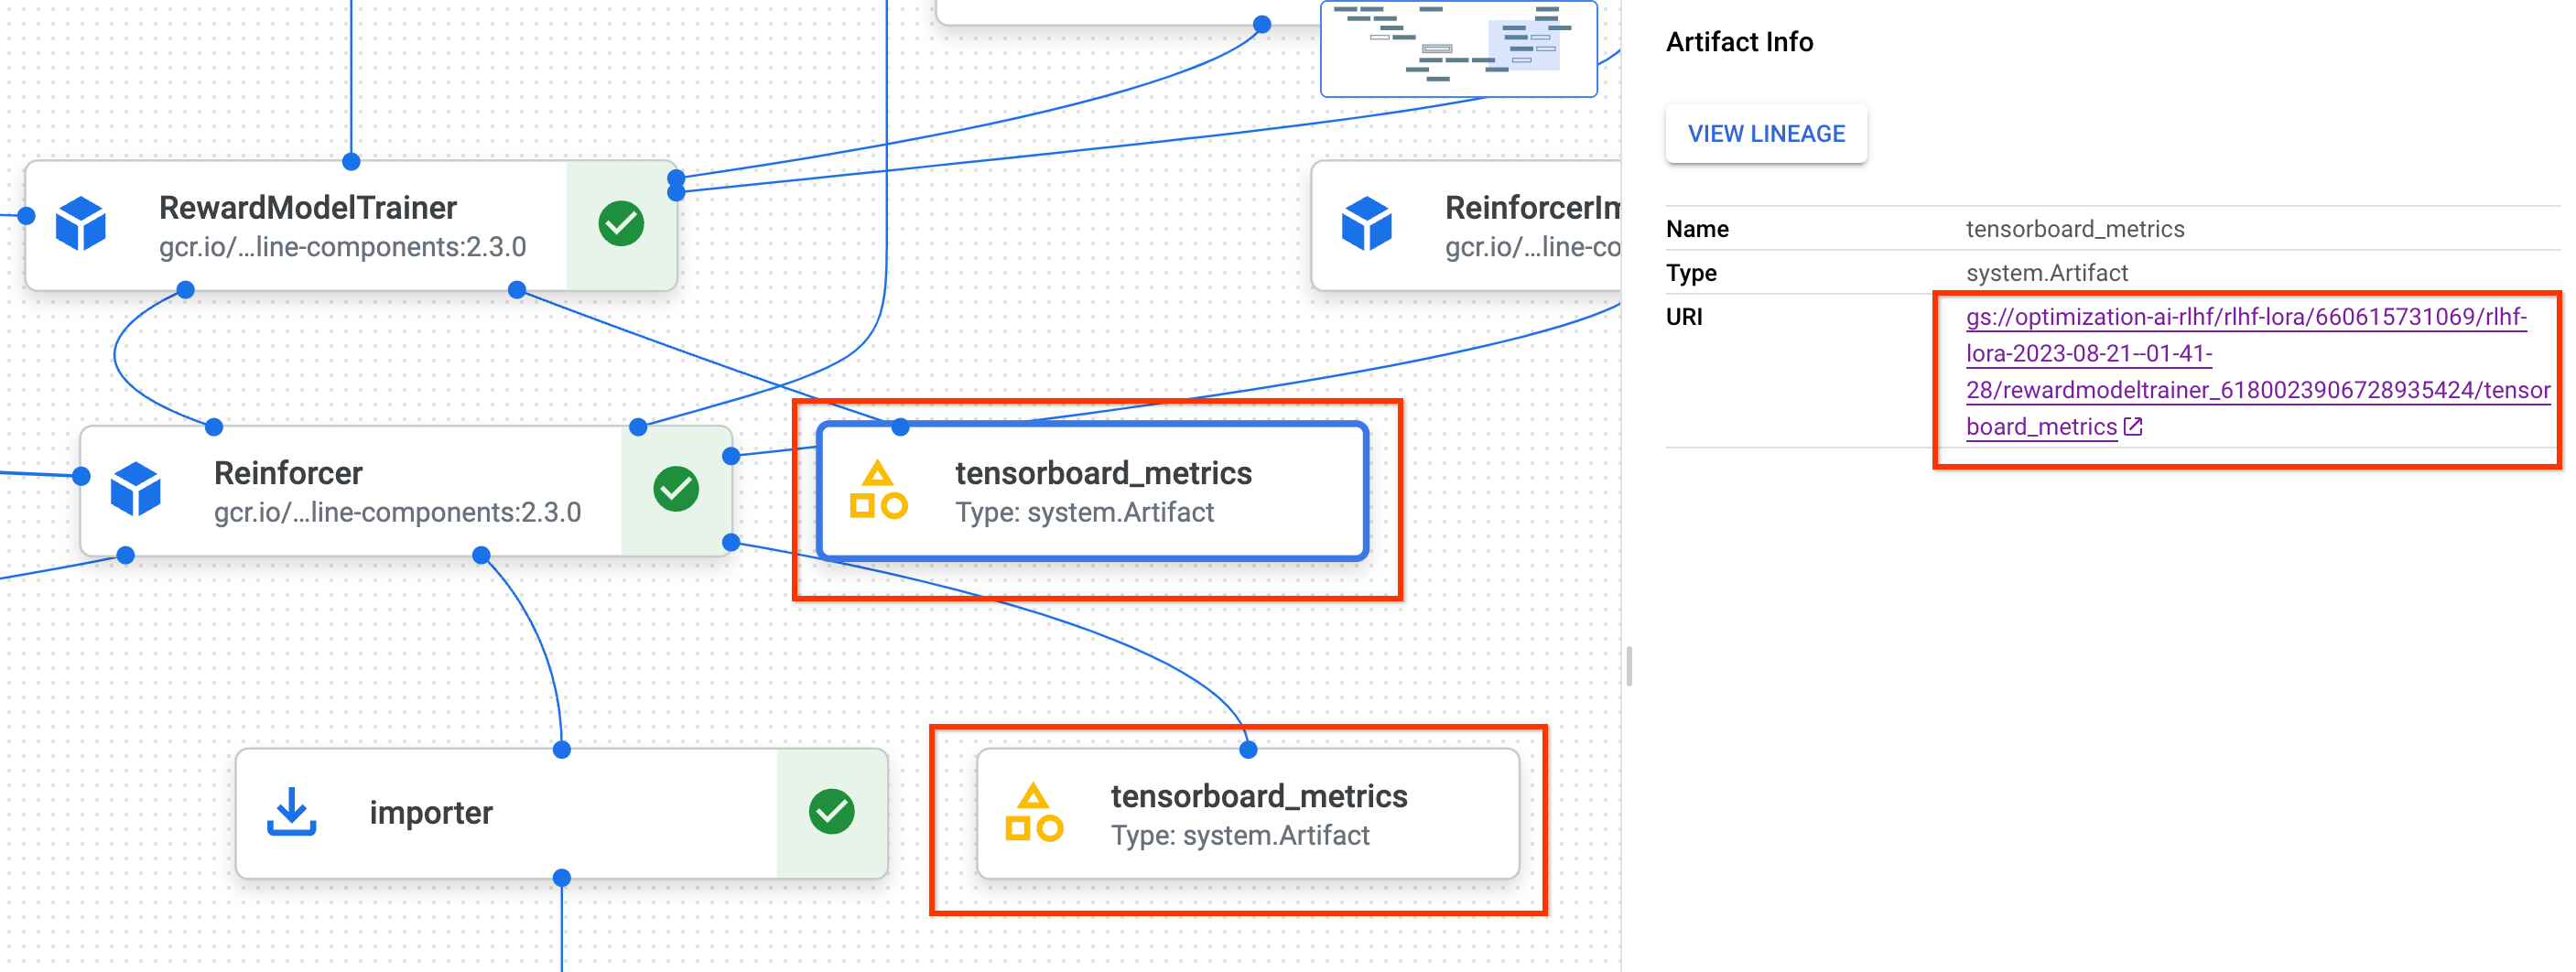

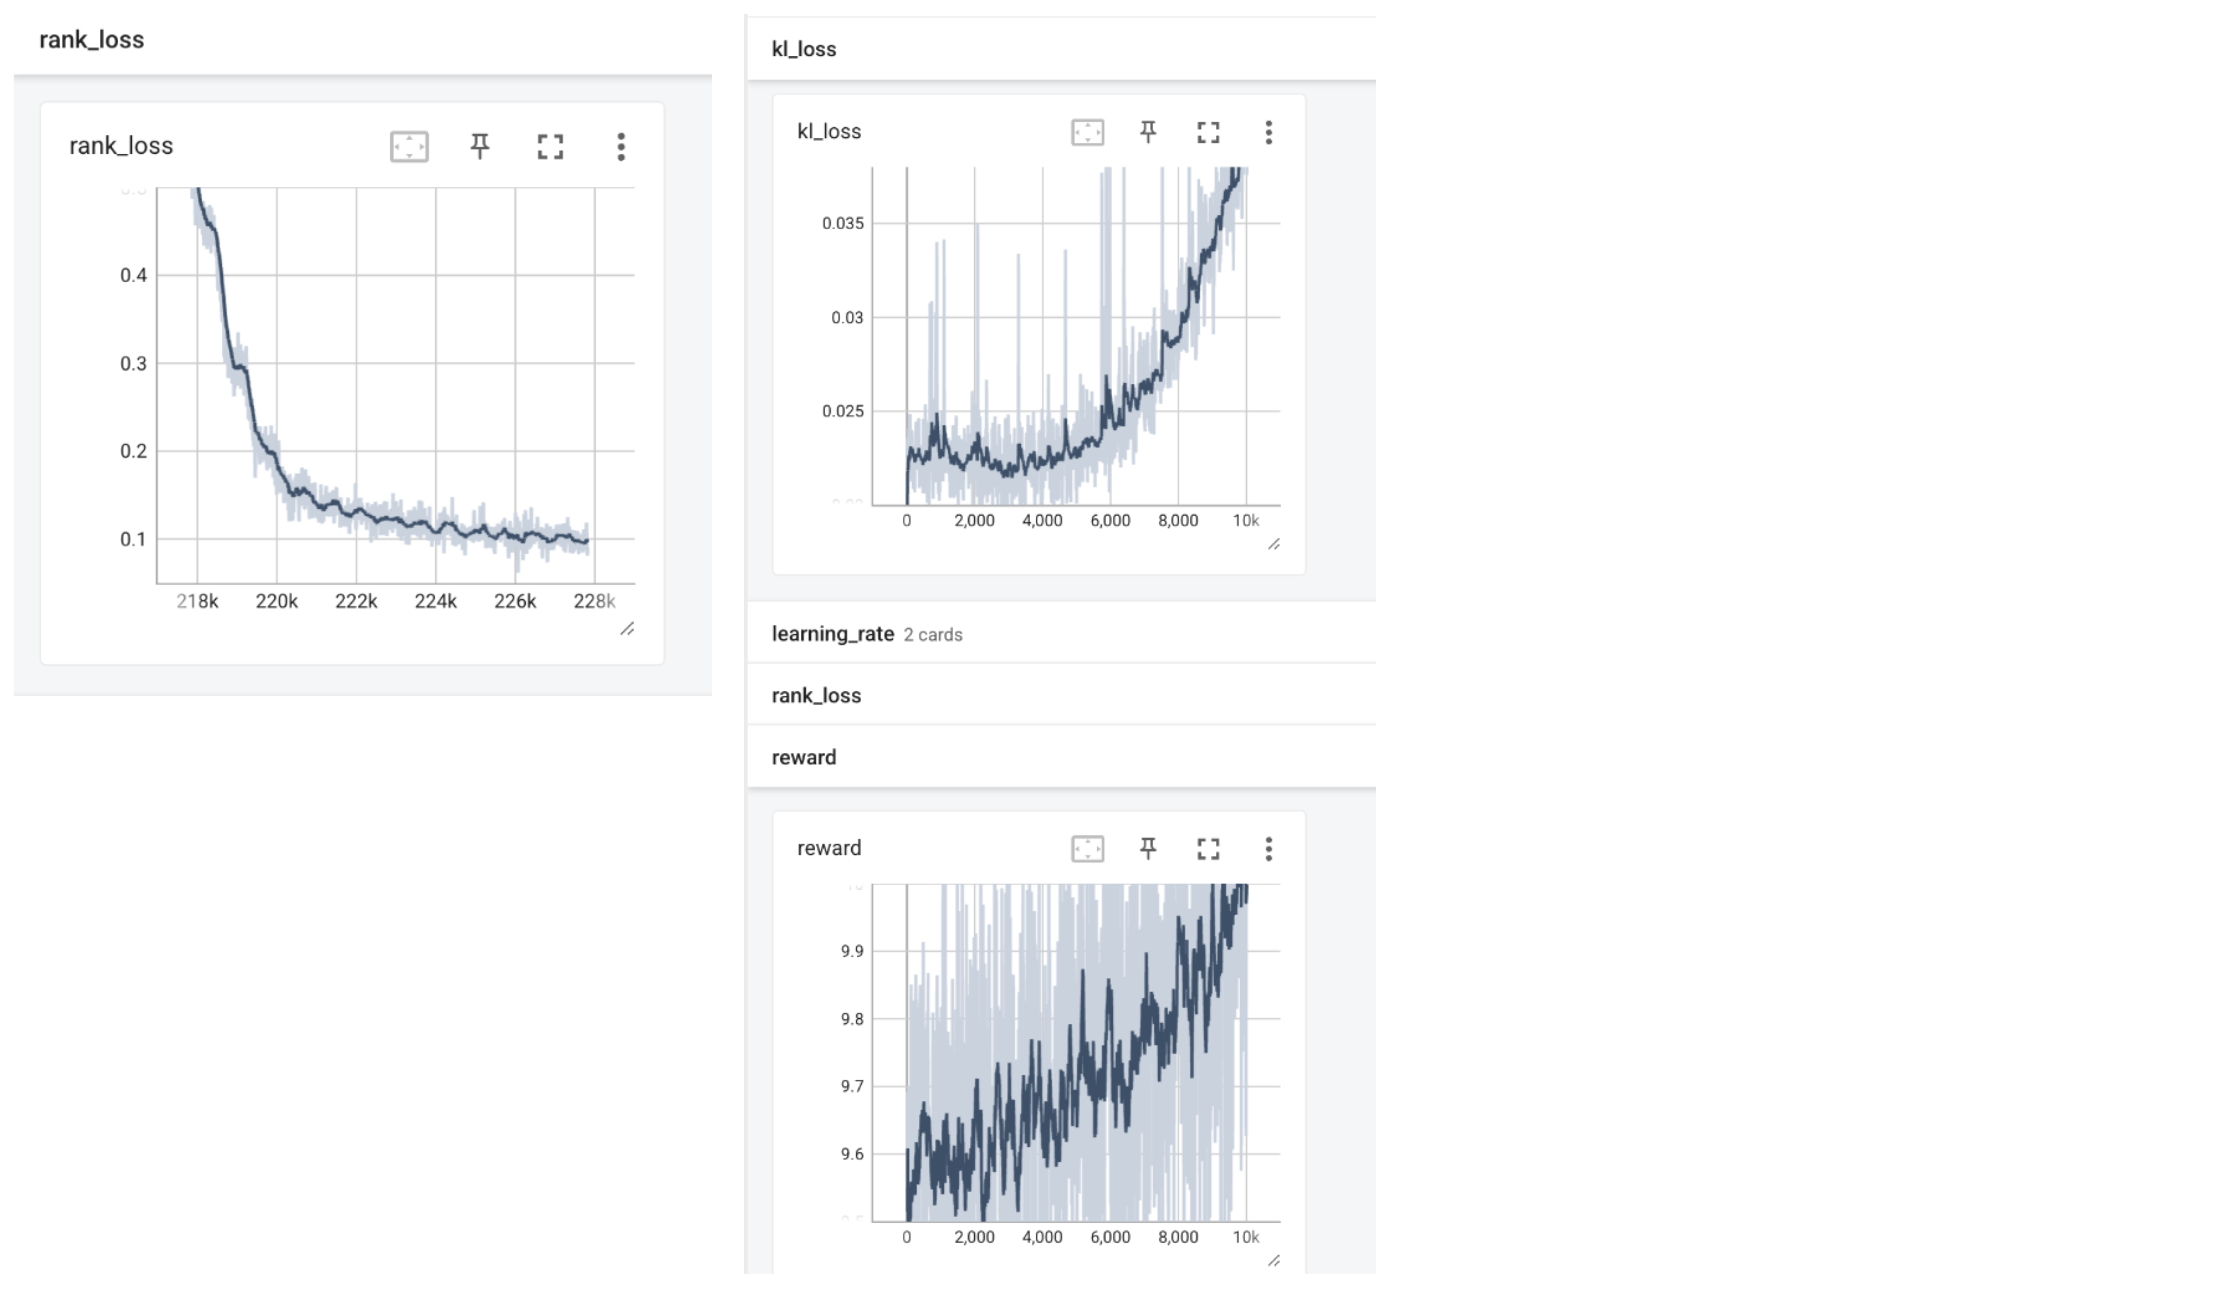

## Bulk Inference
You can perform bulk inference using your tuned model. To perform bulk inference you will need the tuned model path, which can be found in the Vertex Pipelines UI under **Reinforcer** > **Output Parameters** > `output_model_path`. Then run the Bulk Inference pipeline to generate offline predictions from a tuned model checkpoint. See below for details.

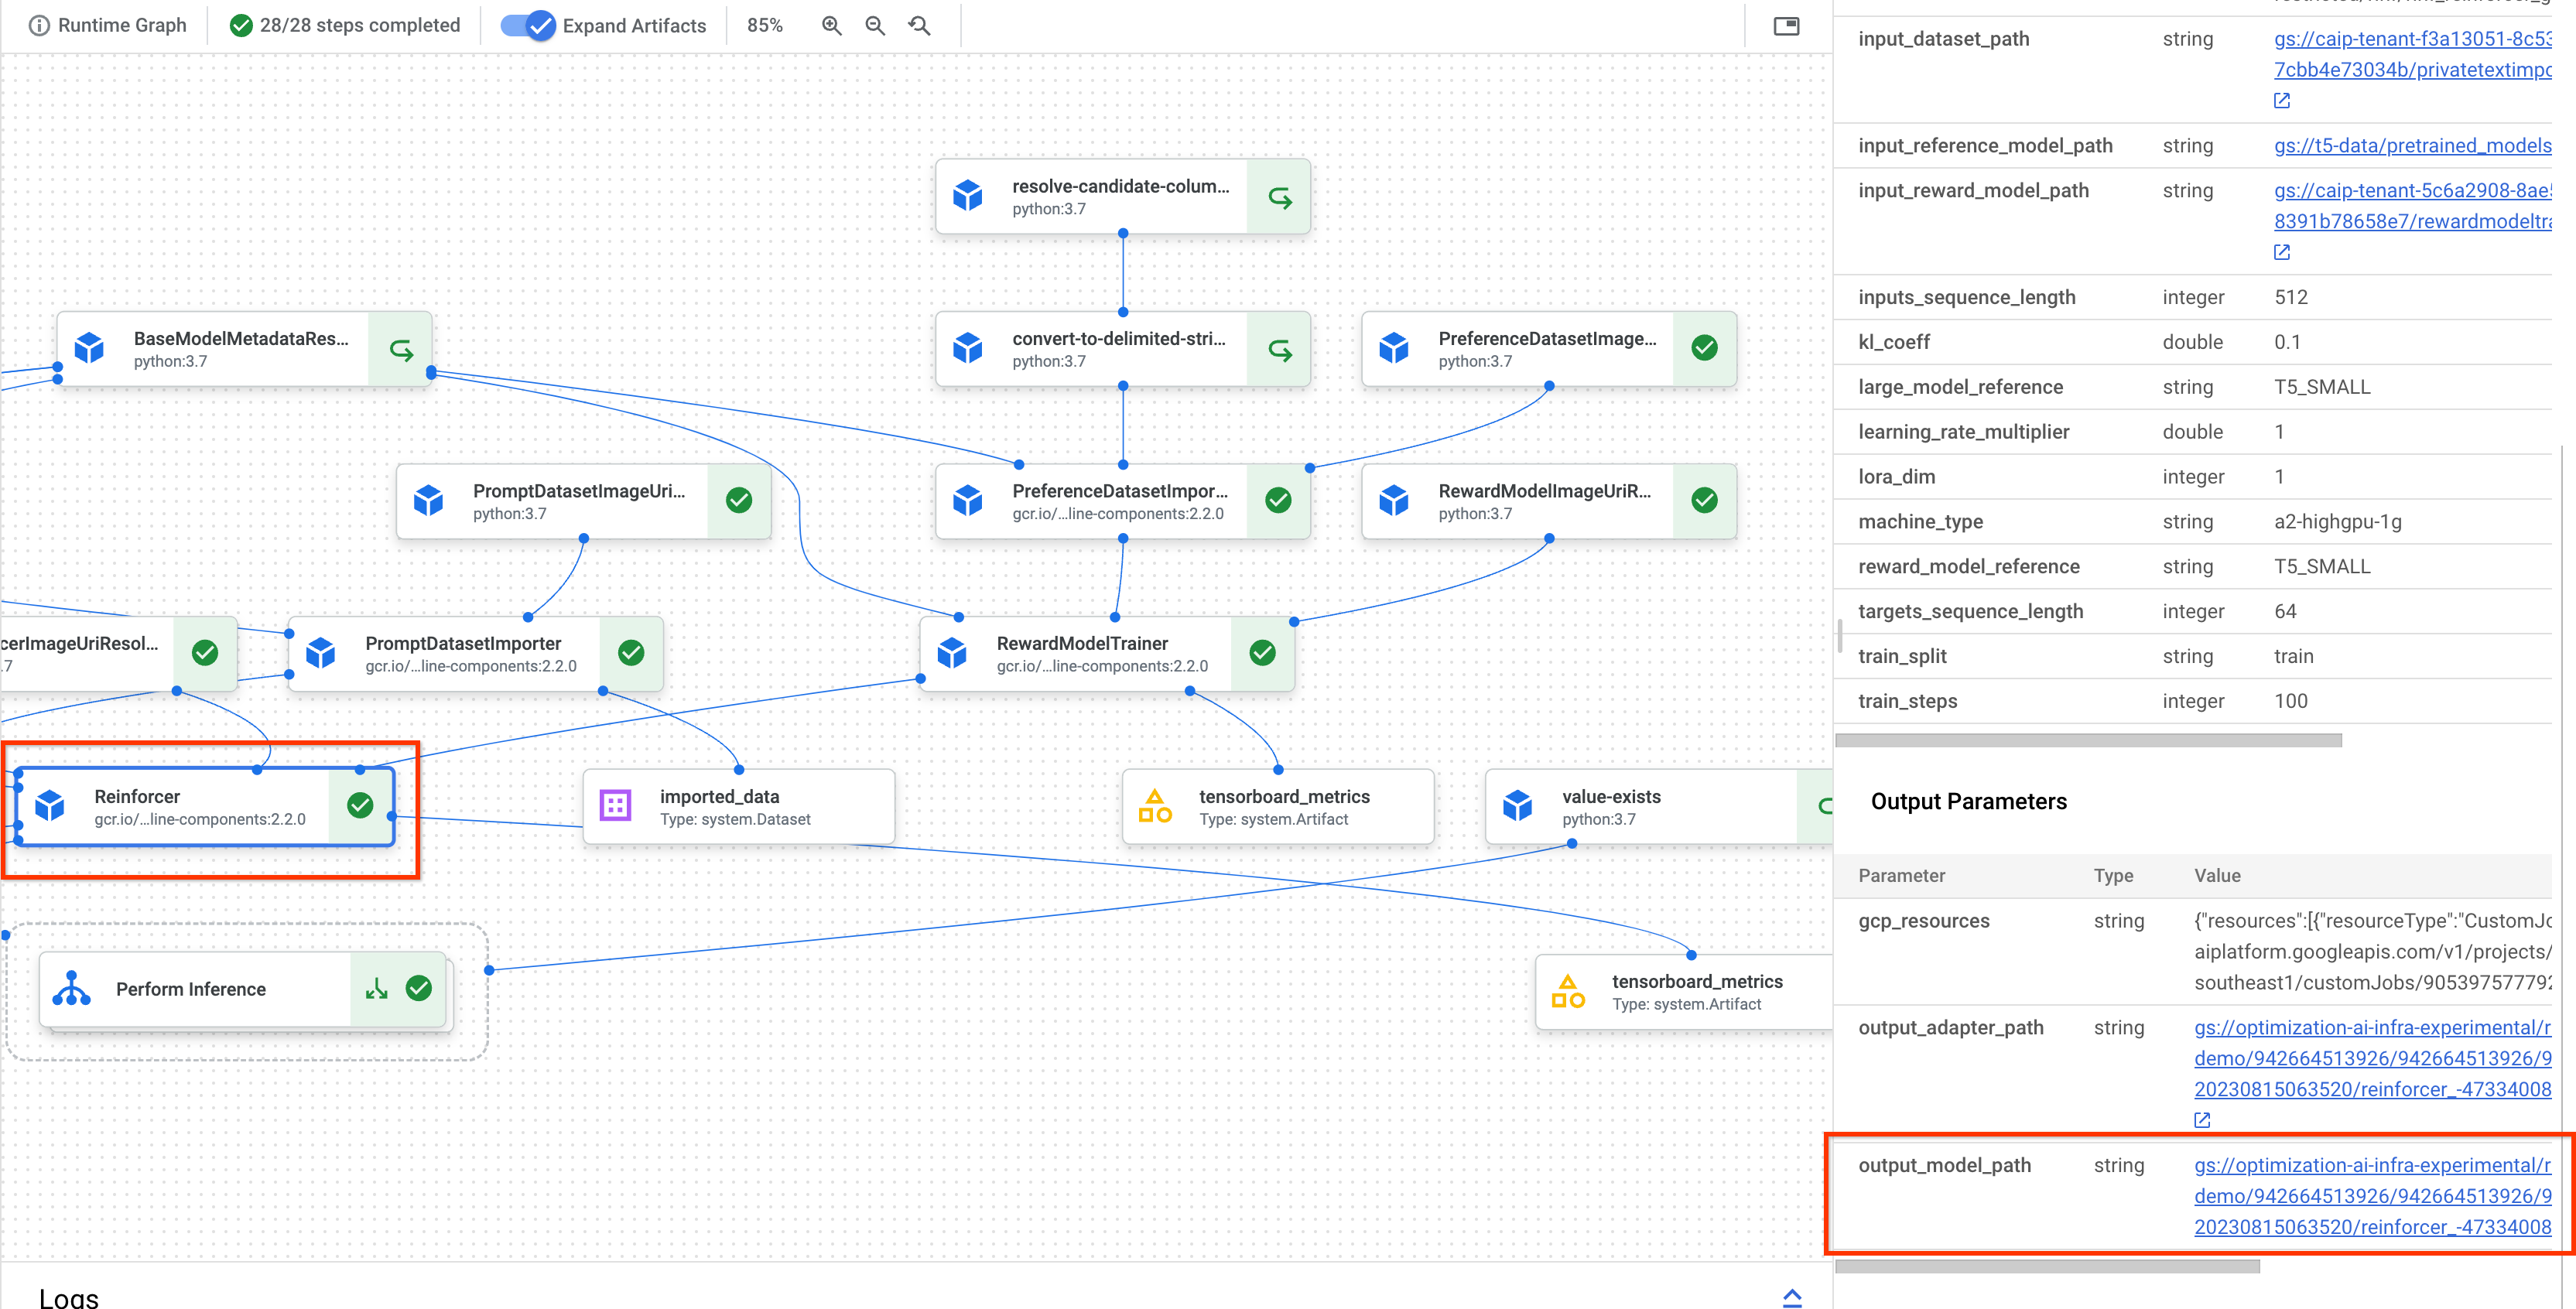

In [ ]:
PIPELINE_ROOT = f"{BUCKET_URI}/tutorial-infer-eval"

# This path is the out-of-the-box llama-2-7b-chat checkpoint. If you want to
# evaluate your own tuned model, PLEASE substitute this path with your own tuned
# checkpoint from the RLHF training pipeline. The tuned model is stored at the
# Reinforcer > Output Parameters > output_model_path.
MODEL_CHECKPOINT = (
    "gs://vertex-rlhf-restricted/pretrained_models/llama/t5x_llama_2_7b_chat"
)

# Create a job via the pipeline template
job = aiplatform.PipelineJob(
    display_name="tutorial-infer-eval",
    pipeline_root=PIPELINE_ROOT,
    template_path="https://us-kfp.pkg.dev/ml-pipeline/llm-rlhf/llama-infer-template/stable",
    parameter_values={
        "large_model_reference": "llama-2-7b-chat",  # see Table 1 for valid values.
        "model_checkpoint": MODEL_CHECKPOINT,
        "prompt_dataset": "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/val/*.jsonl",
        "instruction": "Summarize in less than 50 words.",
    },
)

### Run the pipeline using Vertex AI Pipelines

Execute the following cell to run the pipeline on Vertex AI.

In [ ]:
job.run()

## View the inference result

Go to "Vertex AI Pipelines" in the Google Cloud UI to view the pipeline job. When the pipeline completes, click on **Bulk Inferrer** > **Output Parameters** > `output_prediction_gcs_path`. If you encounter "❗ Requested entity was not found", this is a known issue. Hit the backarrow at the top of the page, you will see your inference results there.

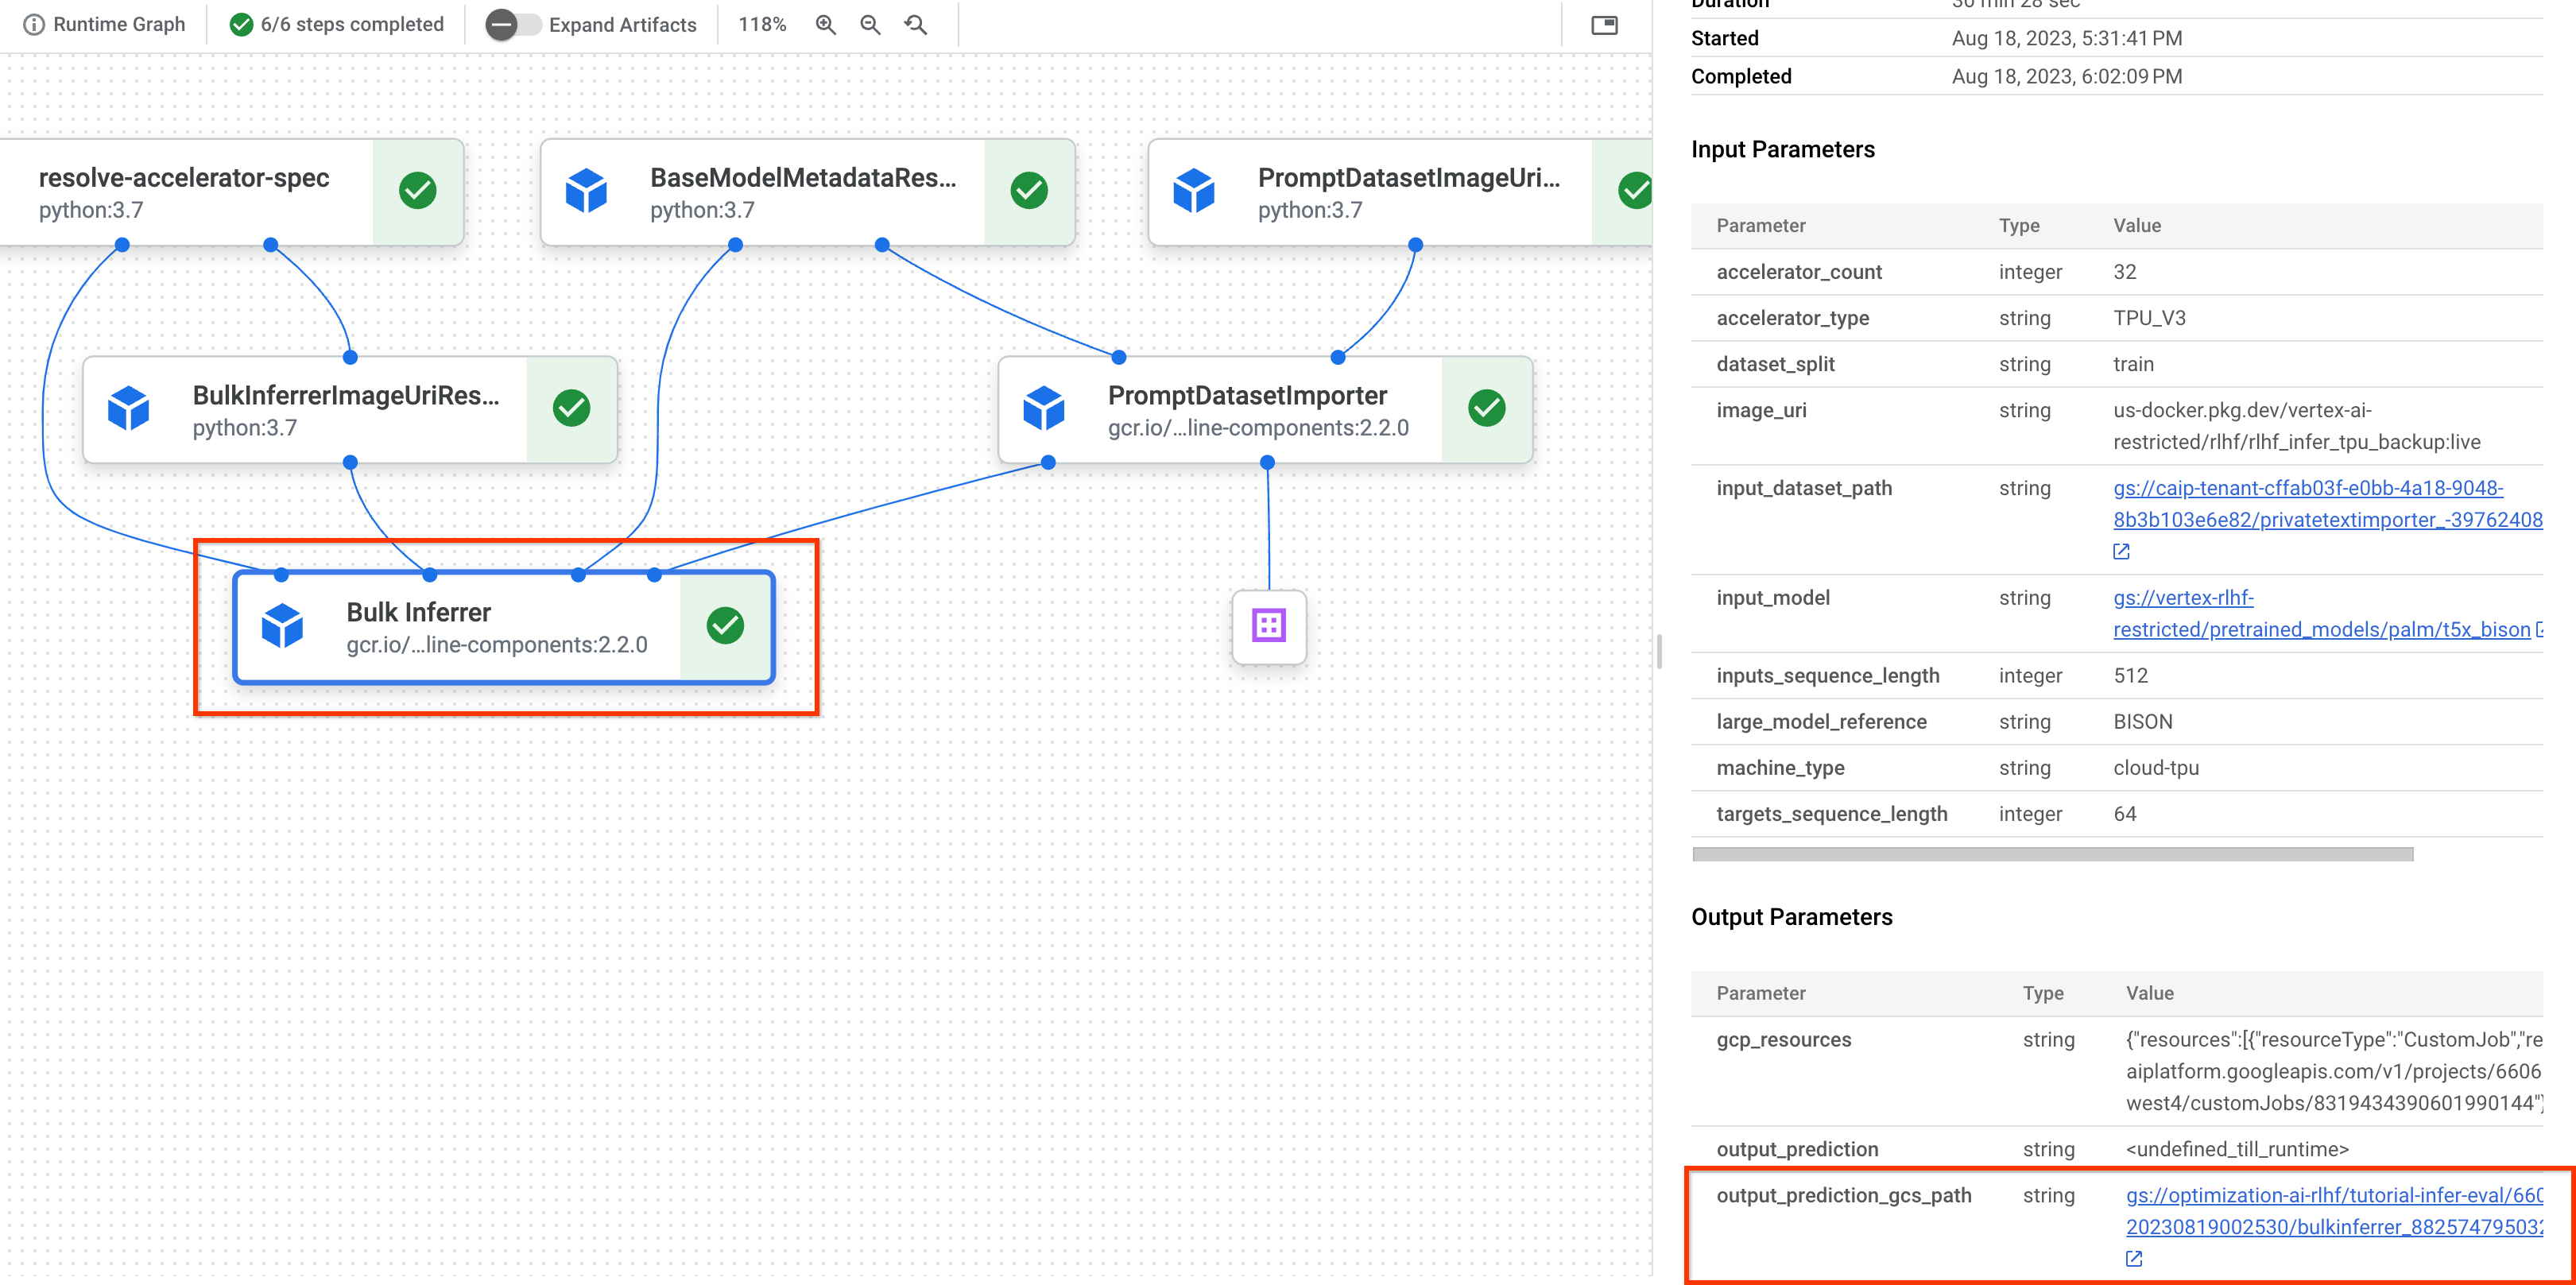

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

In [ ]:
delete_bucket = False

job.delete()

if delete_bucket or os.getenv("ID_TESTING"):
    ! gsutil rm -rf {BUCKET_URI}